In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import itertools
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# **Main functions**

In [2]:
def build_user_profiles(reviews, features):

    user_profiles = {}
    user_reviews_grouped = reviews.groupby('user_id')

    for user_id, user_reviews in user_reviews_grouped:

        valid_reviews = user_reviews[user_reviews['business_id'].isin(features.index)]
        if valid_reviews.empty:
            continue

        reviewed_restaurants_features = features.loc[valid_reviews['business_id']]

        user_ratings = valid_reviews['stars_x'].values

        weights = user_ratings - 3
        weighted_features = reviewed_restaurants_features.multiply(weights, axis=0)
        user_profile = weighted_features.sum(axis=0)

        norm = (user_profile**2).sum()**0.5
        if norm > 0:
            user_profiles[user_id] = user_profile / norm

    return pd.DataFrame.from_dict(user_profiles, orient='index')


def generate_recommendations(user_id, user_profiles,
                             candidate_restaurants, candidate_features,
                             num_recommendations=10, alpha=0.7):

    if user_id not in user_profiles.index:
        print(f"Warning: User {user_id} not found in user profiles.")
        return pd.DataFrame()


    C = candidate_restaurants['stars_y'].mean()
    m = candidate_restaurants['review_count_y'].quantile(0.75)

    def calculate_credibility_score(row, C, m):
        v = row['review_count_y']
        R = row['stars_y']
        return (v / (v + m)) * R + (m / (v + m)) * C

    candidates = candidate_restaurants.copy()
    candidates['credibility_score'] = candidates.apply(lambda row: calculate_credibility_score(row, C, m), axis=1)

    user_profile = user_profiles.loc[[user_id]]
    similarity_scores = cosine_similarity(user_profile, candidate_features)[0]

    results_df = pd.DataFrame({
        'business_id': candidate_features.index,
        'similarity': similarity_scores
    })

    results_df = results_df.merge(candidates[['business_id', 'credibility_score']].drop_duplicates(), on='business_id')

    scaler = MinMaxScaler()
    results_df[['similarity', 'credibility_score']] = scaler.fit_transform(results_df[['similarity', 'credibility_score']])
    results_df['blended_score'] = (alpha * results_df['similarity']) + ((1 - alpha) * results_df['credibility_score'])


    final_recommendations = pd.merge(
        results_df,
        candidates.drop_duplicates(subset=['business_id']), # Use unique restaurants for details
        on='business_id',
        how='left'
    )

    final_recommendations = final_recommendations.sort_values(
        by='blended_score', ascending=False
    ).head(num_recommendations)

    return final_recommendations[['name_y','city','stars_y','review_count_y','categories','blended_score','business_id']]

# **Data loading**

In [7]:
USER_PROP_PATH = "/home/jovyan/work/content/DF_PA_users_proportion_philly_to_all.parquet"
RESTAURANTS_PATH = "/home/jovyan/work/content/DF_PA_only_restaurants_and_open_business.parquet"
FEATURES_PATH = "/home/jovyan/work/content/restaurant_features_df_v7.parquet"

print("Loading data...")
user_prop_philly = pd.read_parquet(USER_PROP_PATH, engine="pyarrow")
pa_restaurants = pd.read_parquet(RESTAURANTS_PATH, engine="pyarrow")
restaurant_features_df = pd.read_parquet(FEATURES_PATH, engine="pyarrow")
print("Data loaded successfully.")

print(f"\npa_restaurants shape: {pa_restaurants.shape}")
print(f"restaurant_features_df shape: {restaurant_features_df.shape}")

Loading data...
Data loaded successfully.

pa_restaurants shape: (903037, 18)
restaurant_features_df shape: (10164, 184)


# **Natural Language Processing**

In [1]:
# Read dataset DF_PA_only_restaurants_and_open_business.parquet

import pandas as pd

df_reviews_PA = pd.read_parquet(
    r"C:\Users\carol\Desktop\Master in Data Science and Engineering FEUP\Year 2\Semester 1\Complex Data Analysis\Project\DF_PA_only_restaurants_and_open_business.parquet"
)

# Display the first 20 rows
display(df_reviews_PA.head(20))

,review_id,user_id,business_id,stars_x,text,date,review_count_x,average_stars,name_y,address,...,attributes.RestaurantsCounterService,attributes.RestaurantsDelivery,attributes.RestaurantsGoodForGroups,attributes.RestaurantsPriceRange2,attributes.RestaurantsReservations,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.Smoking,attributes.WheelchairAccessible,attributes.WiFi
0.0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,33,4.06,Turning Point of North Wales,1460 Bethlehem Pike,...,None,True,True,2,False,True,True,None,True,'free'
2.0,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,9,4.78,Zaika,2481 Grant Ave,...,None,None,True,2,True,None,True,None,None,u'no'
6.0,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,2,5.00,Rittenhouse Grill,1701 Locust St,...,None,True,True,3,True,None,True,None,True,'free'
7.0,Xs8Z8lmKkosqW5mw_sVAoA,IQsF3Rc6IgCzjVV9DE8KXg,eFvzHawVJofxSnD7TgbZtg,5,My absolute favorite cafe in the city. Their b...,2014-11-12 15:30:27,182,3.41,Good Karma Cafe,928 Pine St,...,None,True,True,1,False,None,True,None,None,u'free'
9.0,G_5UczbCBJriUAbxz3J7Tw,clWLI5OZP2ad25ugMVI8gg,x4XdNhp0Xn8lOivzc77J-g,5,Best thai food in the area. Everything was au...,2013-08-15 15:27:51,17,3.24,Thai Place Restaurant,"700 Nutt Rd, Ste 730",...,None,False,True,2,True,True,True,None,True,u'no'
10.0,DyrAIuKl60j_X8Yrrv-kpg,mNsVyC9tQVYtzLOCbh2Piw,MWmXGQ98KbRo3vsS5nZhMA,5,I recently had dinner here with my wife over t...,2014-10-27 02:47:28,12,2.53,Anthony's at Paxon Hollow,850 Paxon Hollow Rd,...,None,False,True,2,True,None,True,None,None,u'no'
11.0,-P5E9BYUaK7s3PwBF5oAyg,Jha0USGDMefGFRLik_xFQg,bMratNjTG5ZFEA6hVyr-xQ,5,First time there and it was excellent!!! It fe...,2017-02-19 13:32:05,116,4.47,Portobello Cafe,1423 Chester Pike,...,None,True,True,2,True,True,True,None,True,u'no'
12.0,40thYphUgIfvJq17QCfTwA,QzCEzH3R7Z6erOGLr3t55Q,0pMj5xUAecW9o1P35B0AMw,5,Great staff always helps and always nice. Alwa...,2017-05-26 13:10:24,14,4.36,Wawa,2544 W Main Street,...,None,True,None,1,None,None,True,None,None,u'free'
13.0,JBWZmBy69VMggxj3eYn17Q,aFa96pz67TwOFu4Weq5Agg,kq5Ghhh14r-eCxlVmlyd8w,5,My boyfriend and I tried this deli for the fir...,2018-08-23 21:39:38,84,3.93,The Coventry Deli,2000 Market St,...,None,True,True,1,False,None,True,None,None,None
14.0,YcLXh-3UC9y6YFAI9xxzPQ,G0DHgkSsDozqUPWtlxVEMw,oBhJuukGRqPVvYBfTkhuZA,4,The only reason I didn't give this restaurant ...,2015-03-05 03:37:54,68,3.25,Square 1682,121 S 17th St,...,None,True,True,2,True,True,True,u'no',True,u'free'


In [2]:
# Filter for city = "Philadelphia"
df_philadelphia = df_reviews_PA[df_reviews_PA["city"].str.lower() == "philadelphia"]

# Show the first 20 rows
display(df_philadelphia.head(20))

# Save to a new CSV file
df_philadelphia.to_parquet(
    r"C:\Users\carol\Desktop\DF_PA_PA-Philadelphia_only_restaurants_and_open_business.parquet",
    index=False
)
print("Saved to DF_PA_PA-Philadelphia_only_restaurants_and_open_business.parquet")

,review_id,user_id,business_id,stars_x,text,date,review_count_x,average_stars,name_y,address,...,attributes.RestaurantsCounterService,attributes.RestaurantsDelivery,attributes.RestaurantsGoodForGroups,attributes.RestaurantsPriceRange2,attributes.RestaurantsReservations,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.Smoking,attributes.WheelchairAccessible,attributes.WiFi
2.0,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,9,4.78,Zaika,2481 Grant Ave,...,None,None,True,2,True,None,True,None,None,u'no'
6.0,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,2,5.00,Rittenhouse Grill,1701 Locust St,...,None,True,True,3,True,None,True,None,True,'free'
7.0,Xs8Z8lmKkosqW5mw_sVAoA,IQsF3Rc6IgCzjVV9DE8KXg,eFvzHawVJofxSnD7TgbZtg,5,My absolute favorite cafe in the city. Their b...,2014-11-12 15:30:27,182,3.41,Good Karma Cafe,928 Pine St,...,None,True,True,1,False,None,True,None,None,u'free'
13.0,JBWZmBy69VMggxj3eYn17Q,aFa96pz67TwOFu4Weq5Agg,kq5Ghhh14r-eCxlVmlyd8w,5,My boyfriend and I tried this deli for the fir...,2018-08-23 21:39:38,84,3.93,The Coventry Deli,2000 Market St,...,None,True,True,1,False,None,True,None,None,None
14.0,YcLXh-3UC9y6YFAI9xxzPQ,G0DHgkSsDozqUPWtlxVEMw,oBhJuukGRqPVvYBfTkhuZA,4,The only reason I didn't give this restaurant ...,2015-03-05 03:37:54,68,3.25,Square 1682,121 S 17th St,...,None,True,True,2,True,True,True,u'no',True,u'free'
16.0,cvQXRFLCyr0S7EgFb4lZqw,ZGjgfSvjQK886kiTzLwfLQ,EtKSTHV5Qx_Q7Aur9o4kQQ,5,"On a scale of one to things that are awesome, ...",2009-10-14 01:15:04,494,4.00,Village Whiskey,118 S 20th St,...,None,True,False,2,False,True,True,u'no',True,u'no'
17.0,r2IBPY_E8AE5_GpsqlONyg,IKbjLnfBQtEyVzEu8CuOLg,VJEzpfLs_Jnzgqh5A_FVTg,4,It was my fiance's birthday and he decided he ...,2014-04-01 13:05:18,800,3.87,Jasmine Rice - Rittenhouse,306 S 16th St,...,None,True,True,2,True,None,True,None,None,u'no'
19.0,mCVyppNwK2qPOJHXgs0p2Q,mNITUu6B2wUKBOa4NmUHJg,NQSnr4RPUScss607oxOaqw,5,My brother came to visit and we wanted to pick...,2016-05-19 06:10:14,1,5.00,Chase's Hop Shop,7235 Rising Sun Ave,...,None,None,True,1,False,False,True,u'no',True,u'free'
21.0,DWbmJF84jRrGaJRmlSSnYQ,aWlojpSpzEICTza3RgGJgg,SIoCIxjn4jLt2O-4DajWJw,4,My go-to spot on a Saturday night! I was real ...,2015-11-18 17:47:29,10,3.60,Mac's Tavern,226 Market St,...,None,True,True,2,False,True,True,u'no',None,u'no'
22.0,-7LkjSPzfVgnVpuVuRuOow,uAu772KpSkb-tPFgZmU-lA,2GYg3liJ9-m6Z67L_4_BRQ,5,I LOVE Weaver's Way and really disagree with s...,2008-12-03 04:13:43,286,3.89,Weavers Way Co-Op,559 Carpenter Ln,...,None,True,None,2,None,None,True,None,True,None


Saved to DF_PA_PA-Philadelphia_only_restaurants_and_open_business.parquet


In [3]:
# Filter for city not equal to "Philadelphia"
df_not_philadelphia = df_reviews_PA[df_reviews_PA["city"].str.lower() != "Philadelphia"]

# Show the first 20 rows
display(df_not_philadelphia.head(20))

# Save to a new CSV file
df_not_philadelphia.to_parquet(
    r"C:\Users\carol\Desktop\DF_PA_not_philadelphia_only_restaurants_and_open_business.parquet",
    index=False
)
print("Saved to DF_PA_not_philadelphia_only_restaurants_and_open_business.parquet")

,review_id,user_id,business_id,stars_x,text,date,review_count_x,average_stars,name_y,address,...,attributes.RestaurantsCounterService,attributes.RestaurantsDelivery,attributes.RestaurantsGoodForGroups,attributes.RestaurantsPriceRange2,attributes.RestaurantsReservations,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.Smoking,attributes.WheelchairAccessible,attributes.WiFi
0.0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,33,4.06,Turning Point of North Wales,1460 Bethlehem Pike,...,None,True,True,2,False,True,True,None,True,'free'
2.0,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,9,4.78,Zaika,2481 Grant Ave,...,None,None,True,2,True,None,True,None,None,u'no'
6.0,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,2,5.00,Rittenhouse Grill,1701 Locust St,...,None,True,True,3,True,None,True,None,True,'free'
7.0,Xs8Z8lmKkosqW5mw_sVAoA,IQsF3Rc6IgCzjVV9DE8KXg,eFvzHawVJofxSnD7TgbZtg,5,My absolute favorite cafe in the city. Their b...,2014-11-12 15:30:27,182,3.41,Good Karma Cafe,928 Pine St,...,None,True,True,1,False,None,True,None,None,u'free'
9.0,G_5UczbCBJriUAbxz3J7Tw,clWLI5OZP2ad25ugMVI8gg,x4XdNhp0Xn8lOivzc77J-g,5,Best thai food in the area. Everything was au...,2013-08-15 15:27:51,17,3.24,Thai Place Restaurant,"700 Nutt Rd, Ste 730",...,None,False,True,2,True,True,True,None,True,u'no'
10.0,DyrAIuKl60j_X8Yrrv-kpg,mNsVyC9tQVYtzLOCbh2Piw,MWmXGQ98KbRo3vsS5nZhMA,5,I recently had dinner here with my wife over t...,2014-10-27 02:47:28,12,2.53,Anthony's at Paxon Hollow,850 Paxon Hollow Rd,...,None,False,True,2,True,None,True,None,None,u'no'
11.0,-P5E9BYUaK7s3PwBF5oAyg,Jha0USGDMefGFRLik_xFQg,bMratNjTG5ZFEA6hVyr-xQ,5,First time there and it was excellent!!! It fe...,2017-02-19 13:32:05,116,4.47,Portobello Cafe,1423 Chester Pike,...,None,True,True,2,True,True,True,None,True,u'no'
12.0,40thYphUgIfvJq17QCfTwA,QzCEzH3R7Z6erOGLr3t55Q,0pMj5xUAecW9o1P35B0AMw,5,Great staff always helps and always nice. Alwa...,2017-05-26 13:10:24,14,4.36,Wawa,2544 W Main Street,...,None,True,None,1,None,None,True,None,None,u'free'
13.0,JBWZmBy69VMggxj3eYn17Q,aFa96pz67TwOFu4Weq5Agg,kq5Ghhh14r-eCxlVmlyd8w,5,My boyfriend and I tried this deli for the fir...,2018-08-23 21:39:38,84,3.93,The Coventry Deli,2000 Market St,...,None,True,True,1,False,None,True,None,None,None
14.0,YcLXh-3UC9y6YFAI9xxzPQ,G0DHgkSsDozqUPWtlxVEMw,oBhJuukGRqPVvYBfTkhuZA,4,The only reason I didn't give this restaurant ...,2015-03-05 03:37:54,68,3.25,Square 1682,121 S 17th St,...,None,True,True,2,True,True,True,u'no',True,u'free'


Saved to DF_PA_not_philadelphia_only_restaurants_and_open_business.parquet


In [ ]:
# Filter for city not equal to "Philadelphia"
df_not_philadelphia = df_reviews_PA[df_reviews_PA["city"].str.lower() != "Philadelphia"]

# Show the first 20 rows
display(df_not_philadelphia.head(20))

# Save to a new CSV file
df_not_philadelphia.to_parquet(
    r"C:\Users\carol\Desktop\DF_PA_not_philadelphia_only_restaurants_and_open_business.parquet",
    index=False
)
print("Saved to DF_PA_not_philadelphia_only_restaurants_and_open_business.parquet")

,review_id,user_id,business_id,stars_x,text,date,review_count_x,average_stars,name_y,address,...,attributes.RestaurantsCounterService,attributes.RestaurantsDelivery,attributes.RestaurantsGoodForGroups,attributes.RestaurantsPriceRange2,attributes.RestaurantsReservations,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.Smoking,attributes.WheelchairAccessible,attributes.WiFi
0.0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,33,4.06,Turning Point of North Wales,1460 Bethlehem Pike,...,None,True,True,2,False,True,True,None,True,'free'
2.0,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,9,4.78,Zaika,2481 Grant Ave,...,None,None,True,2,True,None,True,None,None,u'no'
6.0,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,2,5.00,Rittenhouse Grill,1701 Locust St,...,None,True,True,3,True,None,True,None,True,'free'
7.0,Xs8Z8lmKkosqW5mw_sVAoA,IQsF3Rc6IgCzjVV9DE8KXg,eFvzHawVJofxSnD7TgbZtg,5,My absolute favorite cafe in the city. Their b...,2014-11-12 15:30:27,182,3.41,Good Karma Cafe,928 Pine St,...,None,True,True,1,False,None,True,None,None,u'free'
9.0,G_5UczbCBJriUAbxz3J7Tw,clWLI5OZP2ad25ugMVI8gg,x4XdNhp0Xn8lOivzc77J-g,5,Best thai food in the area. Everything was au...,2013-08-15 15:27:51,17,3.24,Thai Place Restaurant,"700 Nutt Rd, Ste 730",...,None,False,True,2,True,True,True,None,True,u'no'
10.0,DyrAIuKl60j_X8Yrrv-kpg,mNsVyC9tQVYtzLOCbh2Piw,MWmXGQ98KbRo3vsS5nZhMA,5,I recently had dinner here with my wife over t...,2014-10-27 02:47:28,12,2.53,Anthony's at Paxon Hollow,850 Paxon Hollow Rd,...,None,False,True,2,True,None,True,None,None,u'no'
11.0,-P5E9BYUaK7s3PwBF5oAyg,Jha0USGDMefGFRLik_xFQg,bMratNjTG5ZFEA6hVyr-xQ,5,First time there and it was excellent!!! It fe...,2017-02-19 13:32:05,116,4.47,Portobello Cafe,1423 Chester Pike,...,None,True,True,2,True,True,True,None,True,u'no'
12.0,40thYphUgIfvJq17QCfTwA,QzCEzH3R7Z6erOGLr3t55Q,0pMj5xUAecW9o1P35B0AMw,5,Great staff always helps and always nice. Alwa...,2017-05-26 13:10:24,14,4.36,Wawa,2544 W Main Street,...,None,True,None,1,None,None,True,None,None,u'free'
13.0,JBWZmBy69VMggxj3eYn17Q,aFa96pz67TwOFu4Weq5Agg,kq5Ghhh14r-eCxlVmlyd8w,5,My boyfriend and I tried this deli for the fir...,2018-08-23 21:39:38,84,3.93,The Coventry Deli,2000 Market St,...,None,True,True,1,False,None,True,None,None,None
14.0,YcLXh-3UC9y6YFAI9xxzPQ,G0DHgkSsDozqUPWtlxVEMw,oBhJuukGRqPVvYBfTkhuZA,4,The only reason I didn't give this restaurant ...,2015-03-05 03:37:54,68,3.25,Square 1682,121 S 17th St,...,None,True,True,2,True,True,True,u'no',True,u'free'


Saved to DF_PA_not_philadelphia_only_restaurants_and_open_business.parquet


In [ ]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

def normalize_category(cat: str) -> str:
    # lowercase, replace "&" with "and", collapse internal whitespace
    c = cat.lower().replace('&', 'and')
    c = re.sub(r'\s+', ' ', c).strip()
    return c  # keep spaces and split on commas only

# 1) Merge categories per business_id, keeping commas for controlled split
df_reviews_PA['categories'] = df_reviews_PA['categories'].fillna('')
df_unique = (
    df_reviews_PA
      .groupby('business_id')['categories']
      .apply(lambda cats: ','.join(cats))  
      .reset_index()
)

# 2.1) Custom tokenizer - Part 1: split ONLY on commas; keep hyphens and spaces as one token
def comma_tokenizer(doc: str):
    toks = []
    for raw in doc.split(','):
        raw = raw.strip()
        if not raw:
            continue
        norm = normalize_category(raw)
        if re.match(r'^[a-z0-9][a-z0-9\s\-]*$', norm):  
            toks.append(norm)
    return sorted(set(toks))  # dedupe within a business

# 2.2) Custom tokenizer - Part 2: introduce stop words to filter out common non-informative categories

custom_stopwords = ["grocery", "restaurant", "restaurants", "food", "place", "shop", "nightlife", "drugstores", "food delivery services", 
                    "venues and event spaces","caterers","pubs","cocktail bars","food trucks", "bars","event planning and services", 
                    "arts and entertainment", "convenience stores", "stores","shopping", "health and medical", "beauty and spas", "active life", 
                    "local services", "automotive", "home services", "pets", "professional services", "education", 
                    "public services and government", "religious organizations", "real estate", "financial services", "travel services", 
                    "hotels and travel", "nightlife", "food delivery", "food trucks","food", 'accessories','accountants','acupuncture','adult','adult education','adult entertainment',
                    'airlines','airport lounges','airport shuttles','airports','alternative medicine',
                    'amusement parks','antiques','apartments','appliances','appliances and repair','arcades',
                    'art classes','art galleries','art museums','art supplies','arts and crafts',
                    'attraction farms','auto customization','auto glass services','auto parts and supplies',
                    'auto repair','axe throwing','baby gear and furniture','banks and credit unions','bar crawl',
                    'barbers','barre classes','bartenders','beaches','bed and breakfast','beer tours',
                    'beverage store','bike rentals','bikes','boat charters','boat tours','boating',
                    'body contouring','bookkeepers','books','bookstores','botanical gardens','bowling',
                    'brewing supplies','bridal','buddhist temples','building supplies','bus tours',
                    'business consulting','cabinetry','candle stores','cannabis clinics','cannabis dispensaries',
                    'car rental','cardio classes','cards and stationery','casinos','chiropractors',
                    'christmas trees','churches','cigar bars','cinema','club crawl','colleges and universities',
                    'colonics','comedy clubs','comic books','commercial truck dealers','concierge medicine',
                    'contractors','cosmetics and beauty supply','costumes','countertop installation',
                    'country clubs','couriers and delivery services','crane services','csa','dance clubs',
                    'day camps','day spas','dentists','department stores','dietitians','dinner theater',
                    'disc golf','discount store','dive bars','do-it-yourself food','doctors','dry cleaning',
                    'dry cleaning and laundry','educational services','electronics','elementary schools',
                    'ethnic grocery','eyewear and opticians','farmers market','farms','fashion','festivals',
                    'financial advising','fire departments','fireplace services','firewood','fishing',
                    'fitness and instruction','flea markets','floral designers','florists','flowers and gifts',
                    'framing','fruits and veggies','furniture reupholstery','furniture stores','gardeners',
                    'gas stations','gay bars','general dentistry','gift shops','golf','golf lessons','guest houses',
                    'gyms','hair salons','hair stylists','head shops','health coach','health markets','herbal shops',
                    'herbs and spices','hiking','historical tours','hobby shops','home and garden','home decor',
                    'home health care','honduran','horse racing','hospitals','hostels','hotels',
                    'hunting and fishing supplies','indoor playcentre','interior design','international grocery',
                    'internet cafes','irish pub','jazz and blues','jewelry','karaoke','kids activities',
                    'kitchen and bath','kitchen supplies','knitting supplies','lan centers',
                    'landmarks and historical buildings','landscaping','laundromat','laundry services','lawyers',
                    'libraries','livestock feed and supply','local flavor','lounges','mags','marketing',
                    'mass media','massage','massage therapy','medical centers','medical spas','medical supplies',
                    'mini golf','mobile phones','mountain biking','museums','music and dvds','music and video',
                    'music venues','nail salons','nail technicians','newspapers and magazines',
                    'nurseries and gardening','nutritionists','office equipment','oil change stations',
                    'outdoor furniture stores','outdoor gear','outlet stores','paint and sip','parks',
                    'party and event planning','party equipment rentals','party supplies','performing arts',
                    'personal chefs','personal shopping','pest control','pet adoption','pet groomers','pet services',
                    'pet sitting','pet stores','pet training','pharmacy','photography stores and services',
                    'physical therapy','pick your own farms','pilates','playgrounds','pool and billiards','pool halls',
                    'preschools','print media','private tutors','propane','property management','public markets',
                    'public transportation','pumpkin patches','real estate agents','recreation centers',
                    'recycling center','reflexology','resorts','restaurant supplies','saunas','seafood markets',
                    'service stations','shipping centers','shoe stores','shopping centers','skating rinks',
                    'skin care','soccer','social clubs','souvenir shops','speakeasies','special education',
                    'specialty food','specialty schools','spiritual shop','sporting goods','sports bars',
                    'sports betting','sports clubs','sports wear','strip clubs','summer camps','swimming pools',
                    'tabletop games','tableware','tasting classes','tax services','taxis','team building activities',
                    'tennis','thrift stores','ticket sales','tiki bars','tiling','tires','tobacco shops','tours',
                    'towing','toy stores','traditional chinese medicine','train stations','trainers','transportation',
                    'tree services','trinidadian','truck rental','tutoring centers','unofficial yelp events',
                    'urgent care','used','vape shops','veterinarians','video game stores','videos and video game rental',
                    'vintage and consignment','vinyl records','visitor centers','vitamins and supplements',
                    'walking tours','watches','water delivery','water purification services','wedding planning',
                    'weight loss centers','wheel and rim repair','whiskey bars','wholesale stores','wholesalers',
                    'wigs','wine tasting classes','wine tasting room','wine tours','yelp events','yoga','zoos']

# 3) Vectorize using the custom tokenizer
tfidf = TfidfVectorizer(
    tokenizer=comma_tokenizer,
    preprocessor=None,
    lowercase=False,          
    token_pattern=None,
    stop_words=custom_stopwords  
)

restaurant_features_matrix = tfidf.fit_transform(df_unique['categories'])

restaurant_features_df_v7 = pd.DataFrame(
    restaurant_features_matrix.toarray(),
    index=df_unique['business_id'],
    columns=tfidf.get_feature_names_out()
)

print("Restaurant Feature Matrix shape:", restaurant_features_df_v7.shape)


Restaurant Feature Matrix shape: (10164, 184)

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sum TF-IDF scores for each word across all restaurants
word_scores = restaurant_features_df_v7.sum(axis=0)

# Order and pick top 50 categories
top_words = word_scores.sort_values(ascending=False).head(50)

# Generate word cloud
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color="white",
    colormap="viridis"
).generate_from_frequencies(top_words)

# Plot
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Restaurant Categories (TF-IDF)", fontsize=16)
plt.show()

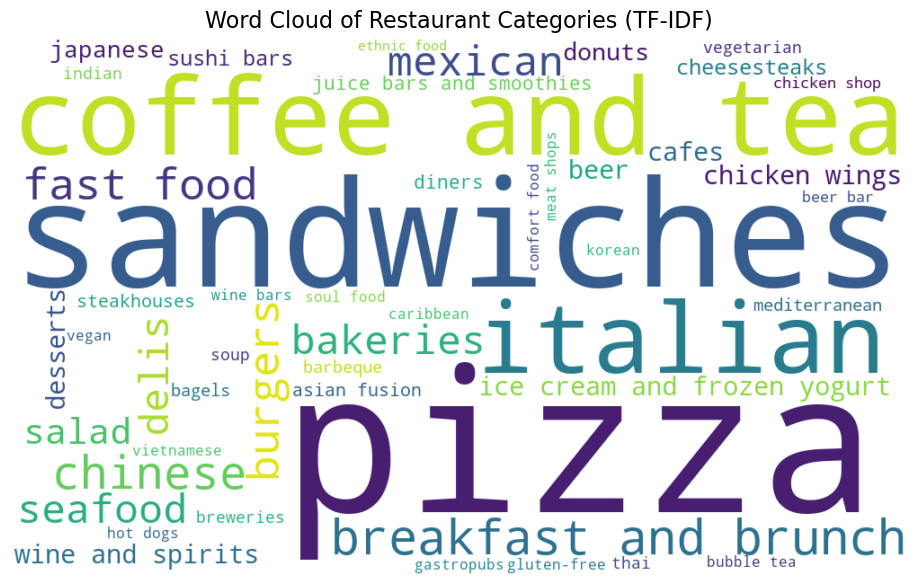

In [ ]:
# Save the DataFrame to a Parquet file
restaurant_features_df_v7.to_parquet(
    "restaurant_features_df_v7.parquet", 
    engine="pyarrow",      
    index=True             
)

print("Saved as restaurant_features_df_v7.parquet")

Saved as restaurant_features_df_v7.parquet

# **Recommender Systems**

In [8]:
# Parameter tuning
# Recommender system
PROP = 0.85
REVIEW_COUNT = 10
ALPHA = 0
NUM_RECOMMENDATIONS = 10

# Evaluation
MIN_REVIEWS_PER_CITY = 10

In [9]:
# Identify target users (Philly)
users_only_philly_ids = user_prop_philly.loc[
    (user_prop_philly['proportion_philly_to_all'] > PROP) &
    (user_prop_philly['philly_review_count'] > REVIEW_COUNT),
    'user_id'
]
users_only_philly_reviews = pa_restaurants[pa_restaurants['user_id'].isin(users_only_philly_ids) & (pa_restaurants['city'] == 'Philadelphia')]
print(f"Identified {len(users_only_philly_ids)} target users for recommendations.")

# Build profiles for target users
print("\nBuilding final taste profiles for target users...")
final_user_profiles = build_user_profiles(users_only_philly_reviews, restaurant_features_df)
print(f"Successfully built {len(final_user_profiles)} user profiles.")

Identified 78 target users for recommendations.

Building final taste profiles for target users...
Successfully built 78 user profiles.


In [10]:
# Final candidate pool (all non-Philly restaurants in PA)
non_philly_restaurants = pa_restaurants[pa_restaurants['city'] != 'Philadelphia']
non_philly_features = restaurant_features_df[restaurant_features_df.index.isin(non_philly_restaurants['business_id'].unique())]

print(f"Final candidate pool size (non-Philly PA): {len(non_philly_restaurants)}")

Final candidate pool size (non-Philly PA): 355243


In [11]:
USER_INDEX = 2

# Select a sample user to generate recommendations for
sample_user_id = final_user_profiles.index[USER_INDEX]

print(f"\n--- Recommendations for user: {sample_user_id} ---")
print("This user reviewed these restaurants in Philadelphia:")
display(users_only_philly_reviews[users_only_philly_reviews['user_id'] == sample_user_id][['name_y', 'stars_x', 'categories']])


--- Recommendations for user: 0DTzZXl163I6wcvA4cbBYw ---
This user reviewed these restaurants in Philadelphia:


,name_y,stars_x,categories
7103,Scannicchio's,2,"Seafood, Italian, Restaurants, Mediterranean"
71531,Domino's Pizza,2,"Sandwiches, Pizza, Restaurants, Chicken Wings"
337984,Isabella Pizza,1,"Burgers, Italian, Restaurants, Pizza, Breakfas..."
349419,Broad Street Diner,5,"Diners, American (Traditional), Restaurants"
385813,Devil's Den,5,"Nightlife, Bars, American (Traditional), Pubs,..."
929575,Station Bar & Grill,5,"Bars, Arts & Entertainment, Nightlife, Sports ..."
1140561,Sam's Morning Glory Diner,5,"Breakfast & Brunch, Restaurants, Diners"
1167708,Pat's King of Steaks,3,"Italian, American (Traditional), Sandwiches, F..."
1250093,Soul Boat,5,"Restaurants, Seafood, Soul Food"
1442542,Ristorante Pesto,5,"Restaurants, Italian"


In [12]:
print(f"\n--- Generating recommendations for sample user: {sample_user_id} ---")

final_recommendations = generate_recommendations(
    user_id=sample_user_id,
    user_profiles=final_user_profiles,
    candidate_restaurants=non_philly_restaurants,
    candidate_features=non_philly_features,
    num_recommendations=NUM_RECOMMENDATIONS,
    alpha=ALPHA
    )

print(f"\n--- Top {NUM_RECOMMENDATIONS} Recommended Restaurants in PA (excluding Philly) ---")
print("\n--- Parameters: ---")
print(f"Alpha: {ALPHA}")
print(f"Number of Recommendations: {NUM_RECOMMENDATIONS}")
print(f"Prop: {PROP}")
print(f"Review Count: {REVIEW_COUNT}")
display(final_recommendations[['name_y', 'city', 'stars_y', 'review_count_y', 'categories', 'blended_score']]
        .sort_values(by='blended_score', ascending=False))


--- Generating recommendations for sample user: 0DTzZXl163I6wcvA4cbBYw ---

--- Top 10 Recommended Restaurants in PA (excluding Philly) ---

--- Parameters: ---
Alpha: 0
Number of Recommendations: 10
Prop: 0.85
Review Count: 10


,name_y,city,stars_y,review_count_y,categories,blended_score
5499,El Limon,Conshohocken,4.5,1001,"Mexican, Restaurants",1.000000
4058,The Couch Tomato Bistro,Manayunk,4.5,681,"Italian, Tapas/Small Plates, Gluten-Free, Bars...",0.967449
3693,Blue Sage Vegetarian Grille,Southampton,4.5,572,"Restaurants, Vegan, Vegetarian",0.950356
1181,Grumpy's Handcarved Sandwiches,Pottstown,5.0,170,"Restaurants, Breakfast & Brunch, Sandwiches",0.938572
1662,DuBu,Elkins Park,4.5,509,"Restaurants, Vegetarian, Korean, Comfort Food,...",0.938145
1999,Leo's Steak Shop,Folcroft,4.5,495,"Sandwiches, Restaurants, Burgers",0.935139
1437,HONEY Restaurant,Doylestown,4.5,472,"American (New), Bars, Tapas/Small Plates, Rest...",0.929937
2035,Carlucci's Grill Yardley,Yardley,4.5,434,"Restaurants, Italian",0.920541
363,IL Granaio,Glen Mills,4.5,425,"Italian, Restaurants, Bars, Nightlife",0.918153
3084,Bittersweet Kitchen,Media,4.5,402,"Restaurants, Coffee & Tea, Food, Breakfast & B...",0.911738


# **Evaluation**

## **"Hold-Out Domain" Simulation**

In [13]:
counts = (pa_restaurants.groupby(['city', 'user_id']).size().reset_index(name='count'))
active_users = counts[counts['count'] > 10]
user_cities = (active_users.groupby('user_id')['city'].unique())


pairs = Counter()
for cities in user_cities:
    if len(cities) > 1:
        for pair in itertools.combinations(sorted(cities), 2):
            pairs[pair] += 1

city_pair_counts = (
    pd.DataFrame(list(pairs.items()), columns=['city_pair', 'shared_users'])
    .sort_values('shared_users', ascending=False)
    .reset_index(drop=True)
)

city_pair_counts.head(10)

,city_pair,shared_users
0,"(King of Prussia, Philadelphia)",45
1,"(Conshohocken, Philadelphia)",34
2,"(Media, Philadelphia)",32
3,"(Ardmore, Philadelphia)",27
4,"(Philadelphia, West Chester)",27
5,"(Bensalem, Philadelphia)",24
6,"(Philadelphia, Wayne)",24
7,"(Philadelphia, Phoenixville)",22
8,"(Philadelphia, Springfield)",19
9,"(Langhorne, Philadelphia)",18


In [14]:
print("Identifying active bridge users for evaluation...")

# Filter for reviews only in the two cities of interest
philly_kop_reviews = pa_restaurants[pa_restaurants['city'].isin(['Philadelphia', 'King of Prussia'])]

# Count reviews for each user in each city
review_counts_per_city = philly_kop_reviews.groupby(['user_id', 'city']).size().reset_index(name='review_count')

# Filter for users who meet the minimum review count in a city
active_reviewers = review_counts_per_city[review_counts_per_city['review_count'] > MIN_REVIEWS_PER_CITY]

# Find users who are "active" in BOTH cities
user_active_city_counts = active_reviewers.groupby('user_id')['city'].nunique()
bridge_user_ids = user_active_city_counts[user_active_city_counts == 2].index

print(f"\nFound {len(bridge_user_ids)} active bridge users with >{MIN_REVIEWS_PER_CITY} reviews in both Philadelphia and King of Prussia.")

Identifying active bridge users for evaluation...

Found 45 active bridge users with >10 reviews in both Philadelphia and King of Prussia.


In [15]:
# Isolate all reviews from our bridge users
bridge_reviews = philly_kop_reviews[philly_kop_reviews['user_id'].isin(bridge_user_ids)]

# Split their history: Philly reviews will be used to build profiles
philly_profile_reviews = bridge_reviews[bridge_reviews['city'] == 'Philadelphia']

# King of Prussia reviews will be our "ground truth" to check against
kop_ground_truth_reviews = bridge_reviews[bridge_reviews['city'] == 'King of Prussia']

# Define the candidate pool for evaluation: all restaurants in King of Prussia
king_of_prussia_restaurants = pa_restaurants[pa_restaurants['city'] == 'King of Prussia']

# Get the feature vectors for ONLY these candidate restaurants
kop_features = restaurant_features_df[restaurant_features_df.index.isin(king_of_prussia_restaurants['business_id'].unique())]

print(f"Profile data shape: {philly_profile_reviews.shape}")
print(f"Ground truth data shape: {kop_ground_truth_reviews.shape}")
print(f"Candidate pool size (KoP): {len(king_of_prussia_restaurants)}")

Profile data shape: (2988, 18)
Ground truth data shape: (740, 18)
Candidate pool size (KoP): 13920


In [16]:
k = NUM_RECOMMENDATIONS
precisions = []
recalls = []

print(f"\nRunning evaluation for {len(bridge_user_ids)} bridge users...")
for user_id in bridge_user_ids:
    # Build a temporary user profile using ONLY their Philly reviews
    user_philly_reviews = philly_profile_reviews[philly_profile_reviews['user_id'] == user_id]
    user_profile = build_user_profiles(user_philly_reviews, restaurant_features_df)

    if user_id not in user_profile.index:
        continue

    # Generate top K recommendations from the King of Prussia pool
    recommendations = generate_recommendations(
        user_id=user_id,
        user_profiles=user_profile,
        candidate_restaurants=king_of_prussia_restaurants,
        candidate_features=kop_features,
        num_recommendations=k,
        alpha=ALPHA
    )

    if recommendations.empty:
        continue

    # Get the ground truth and calculate metrics
    recommended_ids = set(recommendations['business_id'])
    user_kop_reviews = kop_ground_truth_reviews[kop_ground_truth_reviews['user_id'] == user_id]
    ground_truth_ids = set(user_kop_reviews[user_kop_reviews['stars_x'] >= 4]['business_id'])

    if not ground_truth_ids:
        continue

    hits = recommended_ids.intersection(ground_truth_ids)
    precision = len(hits) / k
    recall = len(hits) / len(ground_truth_ids)
    precisions.append(precision)
    recalls.append(recall)

avg_precision = sum(precisions) / len(precisions) if precisions else 0
avg_recall = sum(recalls) / len(recalls) if recalls else 0

print("\n" + "---" * 10)
print("--- EVALUATION RESULTS ---")
print(f"Evaluated on {len(precisions)} users with valid ground truth.")
print("\n--- Parameters: ---")
print(f"Alpha: {ALPHA}")
print(f"Number of recommendations: {NUM_RECOMMENDATIONS}")
print(f"Prop: {PROP}")
print(f"Review count: {REVIEW_COUNT}")
print(f"Min reviews per city: {MIN_REVIEWS_PER_CITY}")
print("\n--- Metrics: ---")
print(f"Average Precision@{k}: {avg_precision:.4f}")
print(f"Average Recall@{k}: {avg_recall:.4f}")
print("---" * 10)


Running evaluation for 45 bridge users...

------------------------------
--- EVALUATION RESULTS ---
Evaluated on 45 users with valid ground truth.

--- Parameters: ---
Alpha: 0
Number of recommendations: 10
Prop: 0.85
Review count: 10
Min reviews per city: 10

--- Metrics: ---
Average Precision@10: 0.3000
Average Recall@10: 0.3636
------------------------------


## **(Mean) Average Precision**

In [17]:
def calculate_average_precision(recommended_ids, ground_truth_ids):
    """
    Calculates the Average Precision (AP) for a single recommendation list.
    """
    if not ground_truth_ids or not recommended_ids:
        return 0.0

    hits = 0
    sum_of_precisions = 0.0

    for i, rec_id in enumerate(recommended_ids):
        if rec_id in ground_truth_ids:
            hits += 1
            precision_at_k = hits / (i + 1)
            sum_of_precisions += precision_at_k

    if len(ground_truth_ids) == 0:
        return 0.0

    return sum_of_precisions / len(ground_truth_ids)

In [18]:
alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
map_scores = []

for alpha in alpha_values:
    print(f"--- Running evaluation for alpha = {alpha} ---")

    ap_scores_for_this_alpha = []

    for user_id in bridge_user_ids:

        user_philly_reviews = philly_profile_reviews[philly_profile_reviews['user_id'] == user_id]
        user_profile = build_user_profiles(user_philly_reviews, restaurant_features_df)

        if user_id not in user_profile.index:
            continue

        recommendations = generate_recommendations(
            user_id=user_id,
            user_profiles=user_profile,
            candidate_restaurants=king_of_prussia_restaurants,
            candidate_features=kop_features,
            num_recommendations=NUM_RECOMMENDATIONS,
            alpha=alpha
        )

        recommended_ids = list(recommendations['business_id'])

        user_kop_reviews = kop_ground_truth_reviews[kop_ground_truth_reviews['user_id'] == user_id]
        ground_truth_ids = set(user_kop_reviews[user_kop_reviews['stars_x'] >= 4]['business_id'])

        if not ground_truth_ids:
            continue

        ap_score = calculate_average_precision(recommended_ids, ground_truth_ids)
        ap_scores_for_this_alpha.append(ap_score)

    if ap_scores_for_this_alpha:
        mean_average_precision = sum(ap_scores_for_this_alpha) / len(ap_scores_for_this_alpha)
    else:
        mean_average_precision = 0.0

    map_scores.append(mean_average_precision)
    print(f"Mean Average Precision (MAP) @{NUM_RECOMMENDATIONS} for alpha={alpha}: {mean_average_precision:.4f}\n")

--- Running evaluation for alpha = 0.1 ---
Mean Average Precision (MAP) @10 for alpha=0.1: 0.1960

--- Running evaluation for alpha = 0.2 ---
Mean Average Precision (MAP) @10 for alpha=0.2: 0.2003

--- Running evaluation for alpha = 0.3 ---
Mean Average Precision (MAP) @10 for alpha=0.3: 0.1807

--- Running evaluation for alpha = 0.4 ---
Mean Average Precision (MAP) @10 for alpha=0.4: 0.1570

--- Running evaluation for alpha = 0.5 ---
Mean Average Precision (MAP) @10 for alpha=0.5: 0.1161

--- Running evaluation for alpha = 0.6 ---
Mean Average Precision (MAP) @10 for alpha=0.6: 0.0848

--- Running evaluation for alpha = 0.7 ---
Mean Average Precision (MAP) @10 for alpha=0.7: 0.0709

--- Running evaluation for alpha = 0.8 ---
Mean Average Precision (MAP) @10 for alpha=0.8: 0.0645

--- Running evaluation for alpha = 0.9 ---
Mean Average Precision (MAP) @10 for alpha=0.9: 0.0590



--- Evaluation Complete. Plotting results... ---


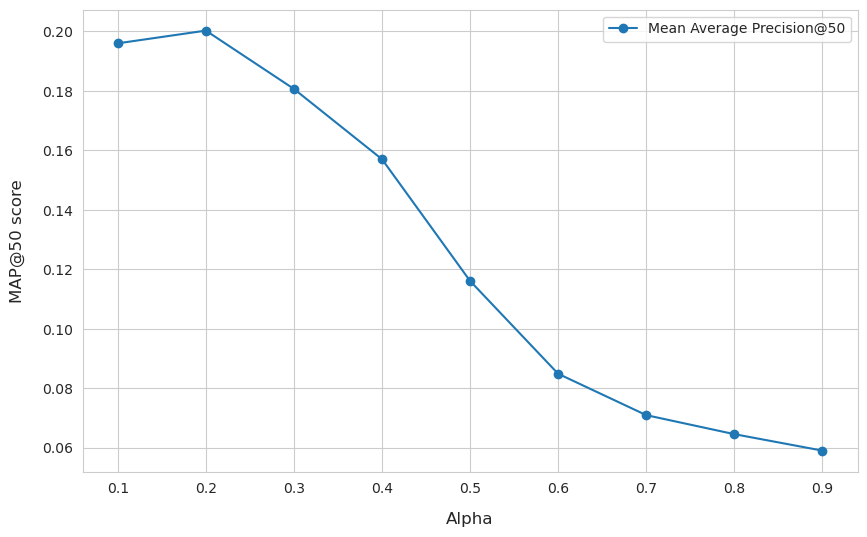

In [19]:
print("--- Evaluation Complete. Plotting results... ---")

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, map_scores, marker='o', linestyle='-', label='Mean Average Precision@50')

#plt.title('Recommender Performance (MAP) vs. Alpha Value', fontsize=16)
plt.xlabel('Alpha', fontsize=12, labelpad=12)
plt.ylabel('MAP@50 score', fontsize=12, labelpad=12)
plt.xticks(alpha_values)
plt.legend()
plt.grid(True)
plt.show()

# **Testing different parameters**

### **Varying alpha**

In [20]:
avg_precision_list = []
avg_recall_list = []

for a in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
  ALPHA = a


  k = NUM_RECOMMENDATIONS
  precisions = []
  recalls = []

  print(f"\nRunning evaluation for {len(bridge_user_ids)} bridge users...")
  for user_id in bridge_user_ids:
      # Build a temporary user profile using ONLY their Philly reviews
      user_philly_reviews = philly_profile_reviews[philly_profile_reviews['user_id'] == user_id]
      user_profile = build_user_profiles(user_philly_reviews, restaurant_features_df)

      if user_id not in user_profile.index:
          continue

      # Generate top K recommendations from the King of Prussia pool
      recommendations = generate_recommendations(
          user_id=user_id,
          user_profiles=user_profile,
          candidate_restaurants=king_of_prussia_restaurants,
          candidate_features=kop_features,
          num_recommendations=k,
          alpha=ALPHA
      )

      if recommendations.empty:
          continue

      # Get the ground truth and calculate metrics
      recommended_ids = set(recommendations['business_id'])
      user_kop_reviews = kop_ground_truth_reviews[kop_ground_truth_reviews['user_id'] == user_id]
      ground_truth_ids = set(user_kop_reviews[user_kop_reviews['stars_x'] >= 4]['business_id'])

      if not ground_truth_ids:
          continue

      hits = recommended_ids.intersection(ground_truth_ids)
      precision = len(hits) / k
      recall = len(hits) / len(ground_truth_ids)
      precisions.append(precision)
      recalls.append(recall)

  avg_precision = sum(precisions) / len(precisions) if precisions else 0
  avg_recall = sum(recalls) / len(recalls) if recalls else 0

  print("\n" + "---" * 10)
  print("--- EVALUATION RESULTS ---")
  print(f"Evaluated on {len(precisions)} users with valid ground truth.")
  print("\n--- Parameters: ---")
  print(f"Alpha: {ALPHA}")
  print(f"Number of recommendations: {NUM_RECOMMENDATIONS}")
  print(f"Prop: {PROP}")
  print(f"Review count: {REVIEW_COUNT}")
  print(f"Min reviews per city: {MIN_REVIEWS_PER_CITY}")
  print("\n--- Metrics: ---")
  print(f"Average Precision@{k}: {avg_precision:.4f}")
  print(f"Average Recall@{k}: {avg_recall:.4f}")
  print("---" * 10)

  avg_precision_list.append(avg_precision)
  avg_recall_list.append(avg_recall)





Running evaluation for 45 bridge users...

------------------------------
--- EVALUATION RESULTS ---
Evaluated on 45 users with valid ground truth.

--- Parameters: ---
Alpha: 0.1
Number of recommendations: 10
Prop: 0.85
Review count: 10
Min reviews per city: 10

--- Metrics: ---
Average Precision@10: 0.2978
Average Recall@10: 0.3623
------------------------------

Running evaluation for 45 bridge users...

------------------------------
--- EVALUATION RESULTS ---
Evaluated on 45 users with valid ground truth.

--- Parameters: ---
Alpha: 0.2
Number of recommendations: 10
Prop: 0.85
Review count: 10
Min reviews per city: 10

--- Metrics: ---
Average Precision@10: 0.2933
Average Recall@10: 0.3568
------------------------------

Running evaluation for 45 bridge users...

------------------------------
--- EVALUATION RESULTS ---
Evaluated on 45 users with valid ground truth.

--- Parameters: ---
Alpha: 0.3
Number of recommendations: 10
Prop: 0.85
Review count: 10
Min reviews per city: 10


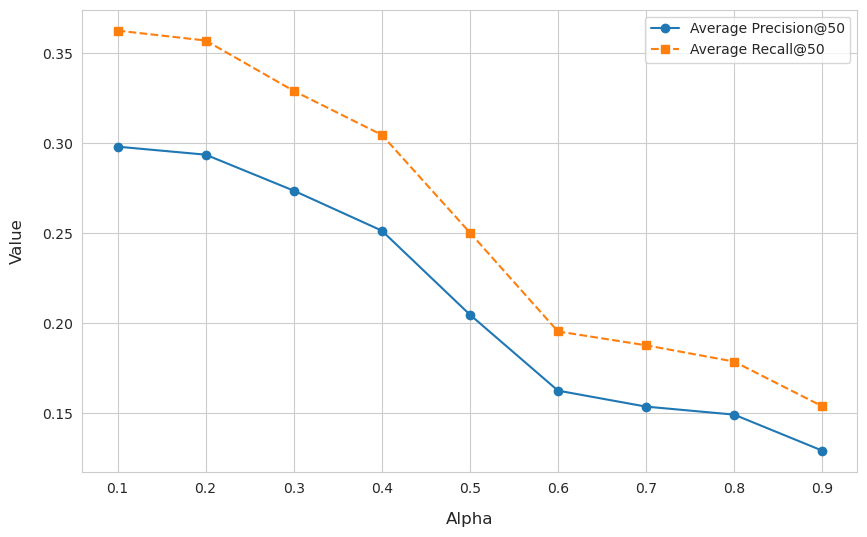

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(10, 6))
plt.plot(alpha_values, avg_precision_list, marker='o', linestyle='-', label='Average Precision@50')
plt.plot(alpha_values, avg_recall_list, marker='s', linestyle='--', label='Average Recall@50')

#plt.title('Recommender Performance vs. Alpha Value', fontsize=16)
plt.xlabel('Alpha', fontsize=12, labelpad=12)
plt.ylabel('Value', fontsize=12, labelpad=12)
plt.xticks(alpha_values)
plt.legend()
plt.grid(True)
plt.show()

# **Baseline model**

## **alpha = 0**

### **P@K/R@K**

In [22]:
ALPHA = 0

k = NUM_RECOMMENDATIONS
precisions = []
recalls = []

print(f"\nRunning evaluation for {len(bridge_user_ids)} bridge users...")
for user_id in bridge_user_ids:
    # Build a temporary user profile using ONLY their Philly reviews
    user_philly_reviews = philly_profile_reviews[philly_profile_reviews['user_id'] == user_id]
    user_profile = build_user_profiles(user_philly_reviews, restaurant_features_df)

    if user_id not in user_profile.index:
        continue

    # Generate top K recommendations from the King of Prussia pool
    recommendations = generate_recommendations(
        user_id=user_id,
        user_profiles=user_profile,
        candidate_restaurants=king_of_prussia_restaurants,
        candidate_features=kop_features,
        num_recommendations=k,
        alpha=ALPHA
    )

    if recommendations.empty:
        continue

    # Get the ground truth and calculate metrics
    recommended_ids = set(recommendations['business_id'])
    user_kop_reviews = kop_ground_truth_reviews[kop_ground_truth_reviews['user_id'] == user_id]
    ground_truth_ids = set(user_kop_reviews[user_kop_reviews['stars_x'] >= 4]['business_id'])

    if not ground_truth_ids:
        continue

    hits = recommended_ids.intersection(ground_truth_ids)
    precision = len(hits) / k
    recall = len(hits) / len(ground_truth_ids)
    precisions.append(precision)
    recalls.append(recall)

avg_precision = sum(precisions) / len(precisions) if precisions else 0
avg_recall = sum(recalls) / len(recalls) if recalls else 0

print("\n" + "---" * 10)
print("--- EVALUATION RESULTS ---")
print(f"Evaluated on {len(precisions)} users with valid ground truth.")
print("\n--- Parameters: ---")
print(f"Alpha: {ALPHA}")
print(f"Number of recommendations: {NUM_RECOMMENDATIONS}")
print(f"Prop: {PROP}")
print(f"Review count: {REVIEW_COUNT}")
print(f"Min reviews per city: {MIN_REVIEWS_PER_CITY}")
print("\n--- Metrics: ---")
print(f"Average Precision@{k}: {avg_precision:.4f}")
print(f"Average Recall@{k}: {avg_recall:.4f}")
print("---" * 10)


Running evaluation for 45 bridge users...

------------------------------
--- EVALUATION RESULTS ---
Evaluated on 45 users with valid ground truth.

--- Parameters: ---
Alpha: 0
Number of recommendations: 10
Prop: 0.85
Review count: 10
Min reviews per city: 10

--- Metrics: ---
Average Precision@10: 0.3000
Average Recall@10: 0.3636
------------------------------


### **Average Precision**

In [23]:
ap_scores_list = []

for user_id in bridge_user_ids:

  user_philly_reviews = philly_profile_reviews[philly_profile_reviews['user_id'] == user_id]
  user_profile = build_user_profiles(user_philly_reviews, restaurant_features_df)

  if user_id not in user_profile.index:
    continue

  recommendations = generate_recommendations(
      user_id=user_id,
      user_profiles=user_profile,
      candidate_restaurants=king_of_prussia_restaurants,
      candidate_features=kop_features,
      num_recommendations=NUM_RECOMMENDATIONS,
      alpha=ALPHA
      )

  recommended_ids = list(recommendations['business_id'])

  user_kop_reviews = kop_ground_truth_reviews[kop_ground_truth_reviews['user_id'] == user_id]
  ground_truth_ids = set(user_kop_reviews[user_kop_reviews['stars_x'] >= 4]['business_id'])

  if not ground_truth_ids:
    continue

  ap_score = calculate_average_precision(recommended_ids, ground_truth_ids)
  ap_scores_list.append(ap_score)

if ap_scores_list:
  mean_average_precision = sum(ap_scores_list) / len(ap_scores_list)
else:
  mean_average_precision = 0.0

print(f"Mean Average Precision (MAP) @{NUM_RECOMMENDATIONS} for alpha={ALPHA}: {mean_average_precision:.4f}\n")

Mean Average Precision (MAP) @10 for alpha=0: 0.2036



## **alpha = 1**

### **P@K/R@K**

In [24]:
ALPHA = 1

k = NUM_RECOMMENDATIONS
precisions = []
recalls = []

print(f"\nRunning evaluation for {len(bridge_user_ids)} bridge users...")
for user_id in bridge_user_ids:
    # Build a temporary user profile using ONLY their Philly reviews
    user_philly_reviews = philly_profile_reviews[philly_profile_reviews['user_id'] == user_id]
    user_profile = build_user_profiles(user_philly_reviews, restaurant_features_df)

    if user_id not in user_profile.index:
        continue

    # Generate top K recommendations from the King of Prussia pool
    recommendations = generate_recommendations(
        user_id=user_id,
        user_profiles=user_profile,
        candidate_restaurants=king_of_prussia_restaurants,
        candidate_features=kop_features,
        num_recommendations=k,
        alpha=ALPHA
    )

    if recommendations.empty:
        continue

    # Get the ground truth and calculate metrics
    recommended_ids = set(recommendations['business_id'])
    user_kop_reviews = kop_ground_truth_reviews[kop_ground_truth_reviews['user_id'] == user_id]
    ground_truth_ids = set(user_kop_reviews[user_kop_reviews['stars_x'] >= 4]['business_id'])

    if not ground_truth_ids:
        continue

    hits = recommended_ids.intersection(ground_truth_ids)
    precision = len(hits) / k
    recall = len(hits) / len(ground_truth_ids)
    precisions.append(precision)
    recalls.append(recall)

avg_precision = sum(precisions) / len(precisions) if precisions else 0
avg_recall = sum(recalls) / len(recalls) if recalls else 0

print("\n" + "---" * 10)
print("--- EVALUATION RESULTS ---")
print(f"Evaluated on {len(precisions)} users with valid ground truth.")
print("\n--- Parameters: ---")
print(f"Alpha: {ALPHA}")
print(f"Number of recommendations: {NUM_RECOMMENDATIONS}")
print(f"Prop: {PROP}")
print(f"Review count: {REVIEW_COUNT}")
print(f"Min reviews per city: {MIN_REVIEWS_PER_CITY}")
print("\n--- Metrics: ---")
print(f"Average Precision@{k}: {avg_precision:.4f}")
print(f"Average Recall@{k}: {avg_recall:.4f}")
print("---" * 10)


Running evaluation for 45 bridge users...

------------------------------
--- EVALUATION RESULTS ---
Evaluated on 45 users with valid ground truth.

--- Parameters: ---
Alpha: 1
Number of recommendations: 10
Prop: 0.85
Review count: 10
Min reviews per city: 10

--- Metrics: ---
Average Precision@10: 0.1311
Average Recall@10: 0.1559
------------------------------


### **Average Precision**

In [25]:
ap_scores_list = []

for user_id in bridge_user_ids:

  user_philly_reviews = philly_profile_reviews[philly_profile_reviews['user_id'] == user_id]
  user_profile = build_user_profiles(user_philly_reviews, restaurant_features_df)

  if user_id not in user_profile.index:
    continue

  recommendations = generate_recommendations(
      user_id=user_id,
      user_profiles=user_profile,
      candidate_restaurants=king_of_prussia_restaurants,
      candidate_features=kop_features,
      num_recommendations=NUM_RECOMMENDATIONS,
      alpha=ALPHA
      )

  recommended_ids = list(recommendations['business_id'])

  user_kop_reviews = kop_ground_truth_reviews[kop_ground_truth_reviews['user_id'] == user_id]
  ground_truth_ids = set(user_kop_reviews[user_kop_reviews['stars_x'] >= 4]['business_id'])

  if not ground_truth_ids:
    continue

  ap_score = calculate_average_precision(recommended_ids, ground_truth_ids)
  ap_scores_list.append(ap_score)

if ap_scores_list:
  mean_average_precision = sum(ap_scores_list) / len(ap_scores_list)
else:
  mean_average_precision = 0.0

print(f"Mean Average Precision (MAP) @{NUM_RECOMMENDATIONS} for alpha={ALPHA}: {mean_average_precision:.4f}\n")

Mean Average Precision (MAP) @10 for alpha=1: 0.0661



### **Social Network Analysis**

In [1]:
# 1) Load the Parquet files and display basic info

import pandas as pd

# Read the user profile matrix
user_profiles_df = pd.read_parquet("user_profiles.parquet")

# Display basic info and head of the DataFrame
print("User profiles:")
print(user_profiles_df.shape)
display(user_profiles_df.head())


User profiles:
(78, 184)


,acai bowls,afghan,african,arabic,argentine,armenian,asian fusion,australian,bagels,bakeries,...,uzbek,vegan,vegetarian,venezuelan,vietnamese,waffles,wine and spirits,wine bars,wineries,wraps
-33OBttPeyt_pUozPxkFEg,0.0,0.0,0.0,0.0,0.0,0.000000,-0.082844,0.0,0.000000,0.000000,...,0.0,0.110742,0.103268,0.0,-0.457813,0.000000,0.0,0.194317,0.0,0.0
-bWX0mGixU6a64fqLWpMXg,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,-0.123010,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
0DTzZXl163I6wcvA4cbBYw,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1w1x35h0V9Nc59IpeEAn9Q,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.212559,0.0,0.000000,0.0,0.0
2OllQugbCFJTPuKD872ETA,0.0,0.0,0.0,0.0,0.0,0.138118,0.143200,0.0,0.118563,0.206029,...,0.0,0.084908,0.079177,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0


In [2]:
# Compute pairwise cosine similarities between user profiles

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

# Keep only numeric features (TF-IDF scores)
X = user_profiles_df.select_dtypes(include=[np.number]).astype(float).values

# Normalize user vectors (so cosine = dot product)
Xn = normalize(X, norm='l2', axis=1)

# Compute pairwise cosine similarity
cos_sim_matrix = cosine_similarity(Xn) 

# Wrap in DataFrame for readability
cos_sim_df = pd.DataFrame(
    cos_sim_matrix,
    index=user_profiles_df.index,   # assuming index = user_id
    columns=user_profiles_df.index
)

# Quick check
print("Cosine similarity matrix shape:", cos_sim_df.shape)
display(cos_sim_df.head())

# Save the cosine similarity matrix to a Parquet file 
cos_sim_df.to_parquet("user_cosine_similarity.parquet")

Cosine similarity matrix shape: (78, 78)


,-33OBttPeyt_pUozPxkFEg,-bWX0mGixU6a64fqLWpMXg,0DTzZXl163I6wcvA4cbBYw,1w1x35h0V9Nc59IpeEAn9Q,2OllQugbCFJTPuKD872ETA,5xfnjLFZjMmA8ByYScE_HA,6DbIeoVWJsBq7aYgx7Q_Rw,6kJFLAHV-tNsBEZaRTqEWQ,8iqhGakujuh2VdtrpHcH2Q,8lEG56y47y_XUpFoaQ8GfA,...,wVtNlH9oAm16m7sJ6RlFtQ,wa8ULvH170VczWlTwC_W9A,wlQM5HVrRq4Y38R651OT_w,ySdQOT6sGt13SNsFjECEPA,ypf85D0eBf6kDoj6f1rANw,z5Ub2FeTWpCJEZZbvagoRw,zAQ9hl0DBBJvGQUf8CBZYA,zURCJsyweyzqcPUzJHxttg,znJdrKZVvLEUnpur9hQLVw,zoS5f0JWThXQnpkxzzUUhQ
-33OBttPeyt_pUozPxkFEg,1.000000,0.011469,-0.002201,-0.000024,0.049115,0.052605,0.026882,0.002685,0.077325,0.031455,...,0.037925,0.185032,0.115578,0.002579,-0.165309,-0.054278,-0.123253,0.097403,-0.016350,0.044462
-bWX0mGixU6a64fqLWpMXg,0.011469,1.000000,-0.139306,-0.039095,-0.370559,-0.336335,-0.262365,-0.505707,-0.479577,-0.183517,...,-0.267438,-0.226420,-0.260369,-0.399301,0.110671,-0.577592,-0.293598,-0.390514,-0.226941,-0.428853
0DTzZXl163I6wcvA4cbBYw,-0.002201,-0.139306,1.000000,0.055198,0.153599,0.351888,0.062757,0.136162,-0.012042,0.108370,...,0.090643,0.058054,0.344662,0.176870,0.379790,0.239410,-0.096468,0.303410,0.109895,0.140358
1w1x35h0V9Nc59IpeEAn9Q,-0.000024,-0.039095,0.055198,1.000000,0.191214,0.168157,0.146828,0.111551,0.011710,0.262091,...,0.089187,0.336077,0.250221,0.122570,0.152384,0.063498,0.066997,0.153590,0.017901,0.157290
2OllQugbCFJTPuKD872ETA,0.049115,-0.370559,0.153599,0.191214,1.000000,0.452215,0.469603,0.683383,0.378854,0.443956,...,0.539953,0.430674,0.550411,0.455460,-0.046420,0.507081,0.099872,0.503401,0.069086,0.578500


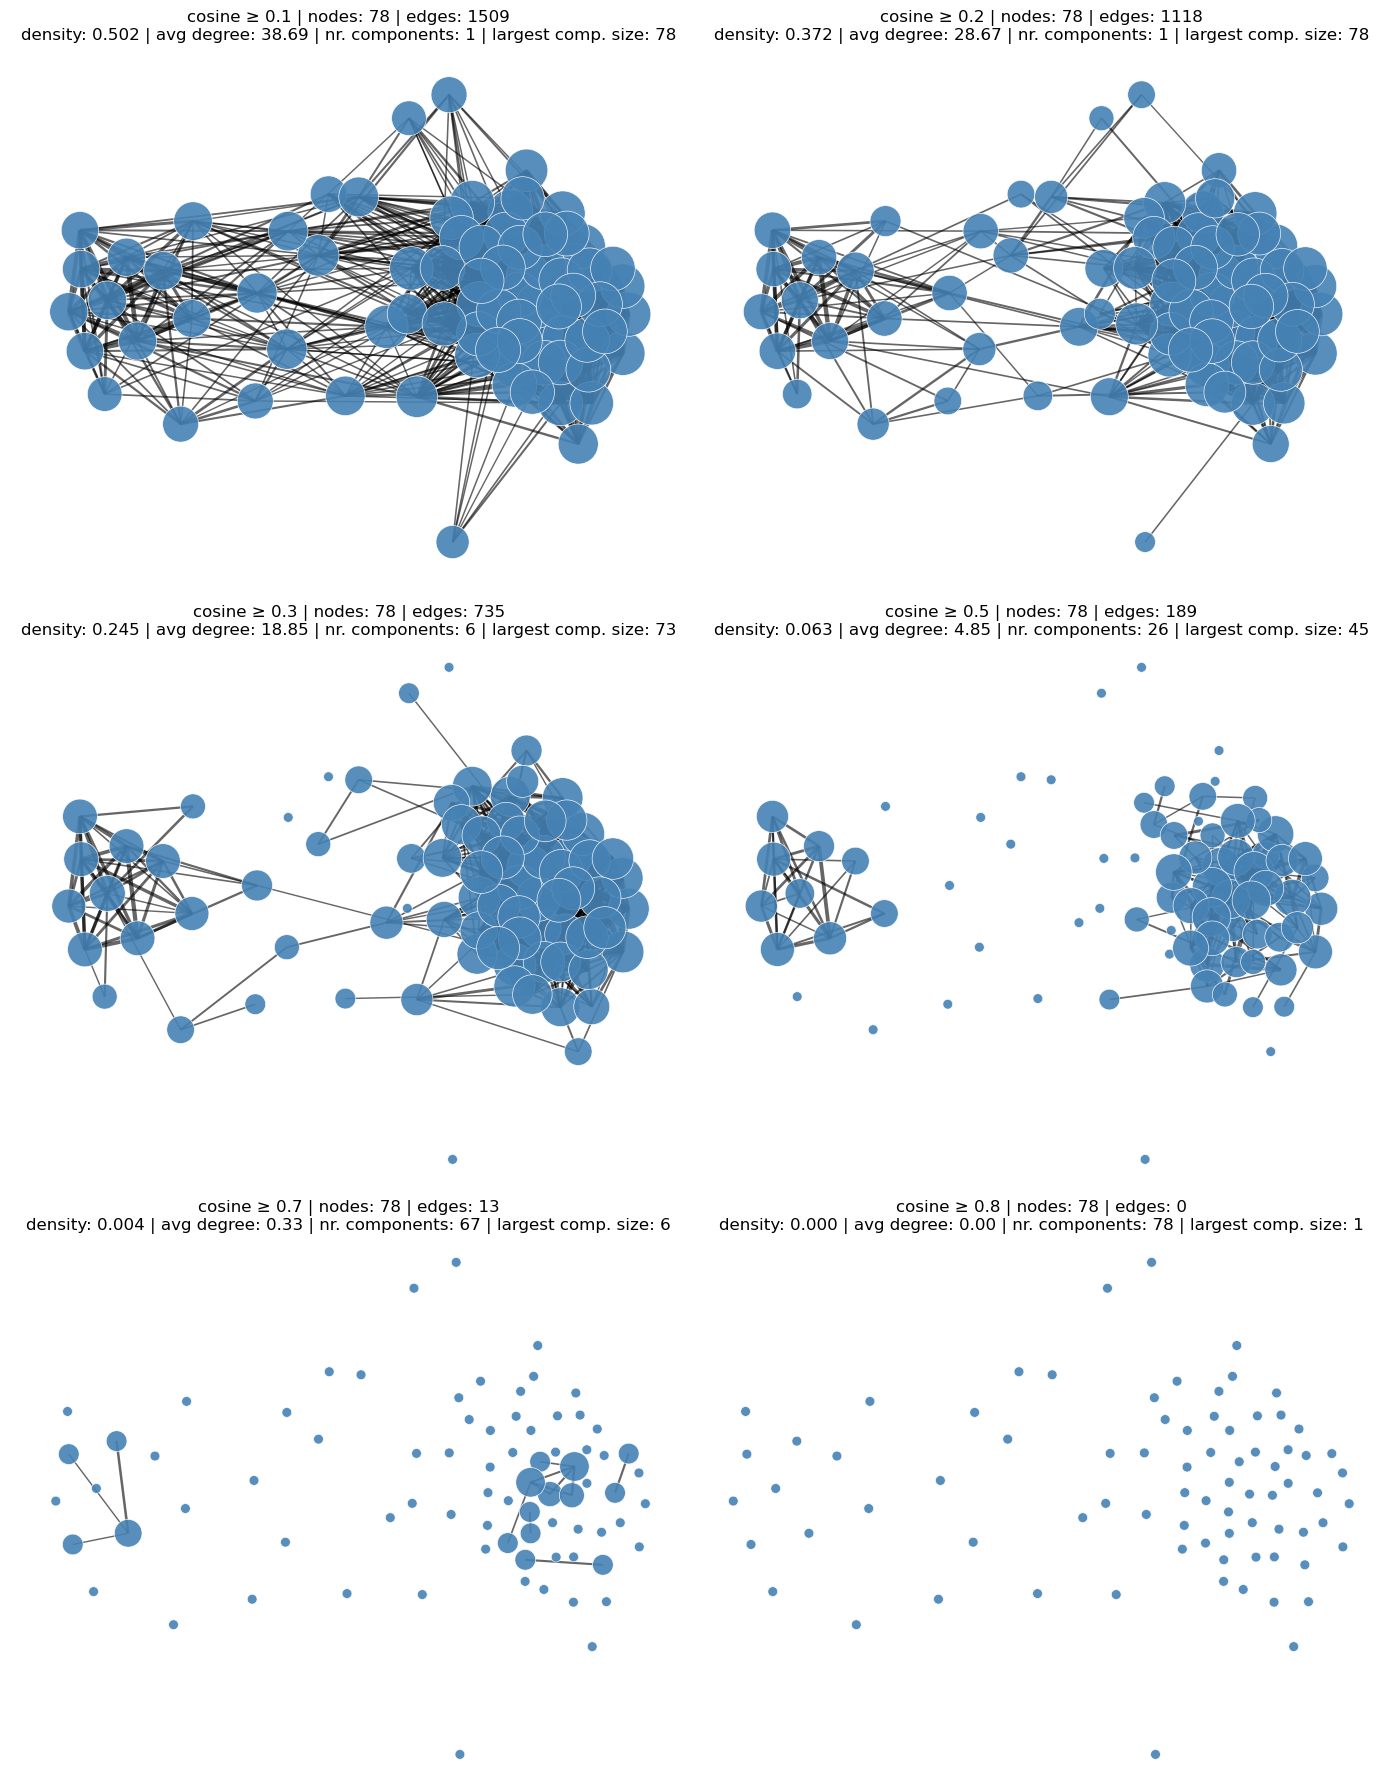


=== Network metrics by threshold ===
 threshold  nodes  edges  density  avg_degree  avg_clustering  n_components  largest_component
       0.1     78   1509 0.502498   38.692308        0.305839             1                 78
       0.2     78   1118 0.372294   28.666667        0.343365             1                 78
       0.3     78    735 0.244755   18.846154        0.366213             6                 73
       0.5     78    189 0.062937    4.846154        0.287811            26                 45
       0.7     78     13 0.004329    0.333333        0.032635            67                  6
       0.8     78      0 0.000000    0.000000        0.000000            78                  1


In [4]:
# User affinity network at multiple cosine thresholds + metrics
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

SIMILARITY_PARQUET = "user_cosine_similarity.parquet"
THRESHOLDS = [0.1, 0.2, 0.3, 0.5, 0.7, 0.8]   # thresholds to test
TOPK_PER_NODE = None                           

# 1) Load cosine similarity matrix
cos_sim_df = pd.read_parquet(SIMILARITY_PARQUET)
users = cos_sim_df.index
assert (cos_sim_df.columns == users).all(), "Columns must match the index (same user order)."

# 2) Symmetric matrix and pruning
A = cos_sim_df.to_numpy().astype(float)
A = np.maximum(A, A.T)
np.fill_diagonal(A, 0.0)

if TOPK_PER_NODE:
    K = min(TOPK_PER_NODE, A.shape[1] - 1)
    pruned = np.zeros_like(A)
    idx = np.argpartition(-A, kth=K, axis=1)[:, :K] 
    rows = np.arange(A.shape[0])[:, None]
    pruned[rows, idx] = A[rows, idx]
    A = np.maximum(pruned, pruned.T) 

# 3) Build a base graph with all positive edges to get a stable layout
i_all, j_all = np.where(A > 0)
edges_all = [(users[i], users[j], float(A[i, j])) for i, j in zip(i_all, j_all) if i < j]
G_all = nx.Graph()
G_all.add_nodes_from(users)
G_all.add_weighted_edges_from(edges_all)

# Spring layout on the base graph (stable across panels)
pos = nx.spring_layout(G_all, k=0.9/np.sqrt(max(1, G_all.number_of_nodes())), seed=42, weight='weight')

# Prepare metrics collection
results = []

# 4) Plot for each threshold
n = len(THRESHOLDS)
cols = min(2, n)
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(7*cols, 6*rows))
axes = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else np.array([axes])

for ax, thr in zip(axes, THRESHOLDS):
    # Build thresholded graph
    i_idx, j_idx = np.where(A >= thr)
    edges = [(users[i], users[j], float(A[i, j])) for i, j in zip(i_idx, j_idx) if i < j]
    G = nx.Graph()
    G.add_nodes_from(users)
    G.add_weighted_edges_from(edges)

    #  Metrics per threshold
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    density = nx.density(G)
    avg_degree = (2.0 * n_edges / n_nodes) if n_nodes > 0 else 0.0
    avg_clust = nx.average_clustering(G, weight='weight') if n_edges > 0 else 0.0
    num_components = nx.number_connected_components(G) if n_nodes > 0 else 0
    largest_comp_size = max((len(c) for c in nx.connected_components(G)), default=0)

    results.append({
        "threshold": thr,
        "nodes": n_nodes,
        "edges": n_edges,
        "density": density,
        "avg_degree": avg_degree,
        "avg_clustering": avg_clust,
        "n_components": num_components,
        "largest_component": largest_comp_size,
    })
    # Node/edge styling
    deg = dict(G.degree())
    node_sizes = [50 + 250*np.log1p(deg.get(n, 0)) for n in G.nodes()]
    edge_widths = [1 + 3*(G[u][v]['weight'] - thr) / max(1e-9, (1 - thr)) for u, v in G.edges()]

    # Draw
    ax.set_title(
        f"cosine ≥ {thr} | nodes: {n_nodes} | edges: {n_edges}\n"
        f"density: {density:.3f} | avg degree: {avg_degree:.2f} | nr. components: {num_components} | largest comp. size: {largest_comp_size}"
    )
    if n_edges == 0:
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="steelblue",
                               alpha=0.9, linewidths=0.5, edgecolors='white', ax=ax)
    else:
        nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='black', alpha=0.6, ax=ax)
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="steelblue",
                               alpha=0.9, linewidths=0.5, edgecolors='white', ax=ax)
    ax.axis('off')

# Hide any unused axes (if any)
for ax in axes[len(THRESHOLDS):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# 5) Summarize metrics
df_metrics = pd.DataFrame(results).sort_values("threshold")
print("\n=== Network metrics by threshold ===")
print(df_metrics.to_string(index=False))

# save metrics to CSV
df_metrics.to_csv("network_metrics_by_threshold.csv", index=False)

   Threshold  Nodes  Edges  Modularity
0        0.1     78   1509    0.162847
1        0.2     78   1118    0.177010
2        0.3     78    735    0.216287
3        0.5     78    189    0.386432
4        0.7     78     13    0.639222
5        0.8     78      0    0.000000


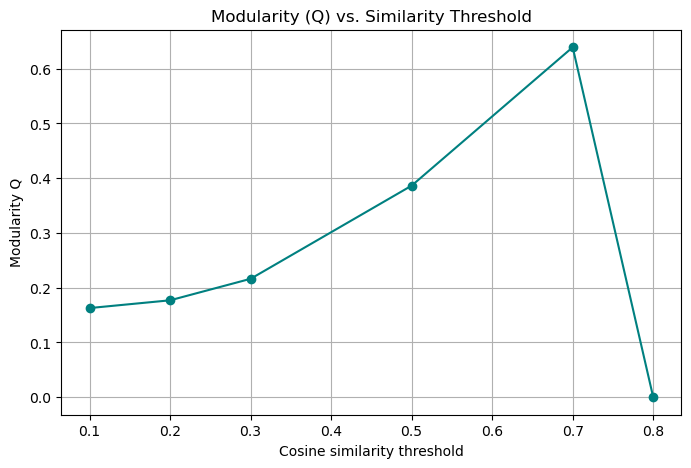

In [5]:
# Justifying threshold chosen via modularity Q calculation

import networkx as nx
import community as community_louvain  # pip install python-louvain

def compute_modularity(G):
    """
    Compute modularity Q for a given graph G using Louvain communities.
    Works for weighted graphs.
    """
    if G.number_of_edges() == 0:
        return 0.0  # No edges = no structure
    
    partition = community_louvain.best_partition(G, weight='weight', random_state=42)
    Q = community_louvain.modularity(partition, G, weight='weight')
    return Q

import pandas as pd

thresholds = [0.1, 0.2, 0.3, 0.5, 0.7, 0.8]
results = []

for t in thresholds:
    A = cos_sim_df.to_numpy()
    np.fill_diagonal(A, 0.0)
    A = np.maximum(A, A.T)
    users = cos_sim_df.index
    
    i_idx, j_idx = np.where(A >= t)
    edges = [(users[i], users[j], float(A[i, j])) for i, j in zip(i_idx, j_idx) if i < j]

    G = nx.Graph()
    G.add_nodes_from(users)
    G.add_weighted_edges_from(edges)
    
    Q = compute_modularity(G)
    results.append((t, G.number_of_nodes(), G.number_of_edges(), Q))

df_mod = pd.DataFrame(results, columns=['Threshold', 'Nodes', 'Edges', 'Modularity'])
print(df_mod)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(df_mod['Threshold'], df_mod['Modularity'], marker='o', color='teal')
plt.title("Modularity (Q) vs. Similarity Threshold")
plt.xlabel("Cosine similarity threshold")
plt.ylabel("Modularity Q")
plt.grid(True)
plt.show()


In [6]:
# Extract & save user communities at threshold = 0.5
import numpy as np
import pandas as pd
import networkx as nx
import community as community_louvain  # pip install python-louvain

THR = 0.5
OUT_CSV = "user_communities_thr_0p5.csv"

# Build thresholded graph
i_idx, j_idx = np.where(A >= THR)
edges = [(users[i], users[j], float(A[i, j])) for i, j in zip(i_idx, j_idx) if i < j]
G = nx.Graph()
G.add_nodes_from(users)
G.add_weighted_edges_from(edges)

if G.number_of_edges() == 0:
    # No edges → nobody belongs to any community
    df_thr = pd.DataFrame({"user": users, "community": np.nan, "in_component": False})
else:
    # Largest connected component (recommended for community detection)
    lcc_nodes = max(nx.connected_components(G), key=len)
    Gc = G.subgraph(lcc_nodes).copy()
    partition = community_louvain.best_partition(Gc, weight="weight", random_state=42)  # dict {user: comm_id}

    # Record all users (NaN for those outside LCC)
    rows = []
    in_comp_set = set(Gc.nodes())
    for u in users:
        rows.append({
            "user": u,
            "community": partition[u] if u in partition else np.nan,
            "in_component": (u in in_comp_set)
        })
    df_thr = pd.DataFrame(rows)

# Save CSV
df_thr.to_csv(OUT_CSV, index=False)
print(f"Saved community assignments @ cosine ≥ {THR} → {OUT_CSV}")

Saved community assignments @ cosine ≥ 0.5 → user_communities_thr_0p5.csv


Users: 78 | Edges (cosine ≥ 0.5): 189
Largest component: 45 nodes, 164 edges

Community sizes:
  Community 0: 8 users
  Community 1: 13 users
  Community 2: 11 users
  Community 3: 9 users
  Community 4: 4 users

Top categories per community:

Community 0 (n=8):
  breakfast and brunch: 0.322
  sandwiches: 0.266
  italian: 0.240
  mexican: 0.182
  asian fusion: 0.161
  sushi bars: 0.159
  pizza: 0.147
  salad: 0.129

Community 1 (n=13):
  breakfast and brunch: 0.469
  mexican: 0.198
  sandwiches: 0.164
  seafood: 0.136
  coffee and tea: 0.130
  burgers: 0.128
  diners: 0.116
  desserts: 0.112

Community 2 (n=11):
  italian: 0.380
  pizza: 0.273
  breakfast and brunch: 0.227
  sandwiches: 0.143
  gastropubs: 0.142
  cafes: 0.139
  wine bars: 0.130
  desserts: 0.113

Community 3 (n=9):
  sandwiches: 0.271
  vegan: 0.234
  pizza: 0.222
  delis: 0.156
  sushi bars: 0.149
  seafood: 0.148
  breakfast and brunch: 0.144
  coffee and tea: 0.131

Community 4 (n=4):
  coffee and tea: 0.328
  bubb

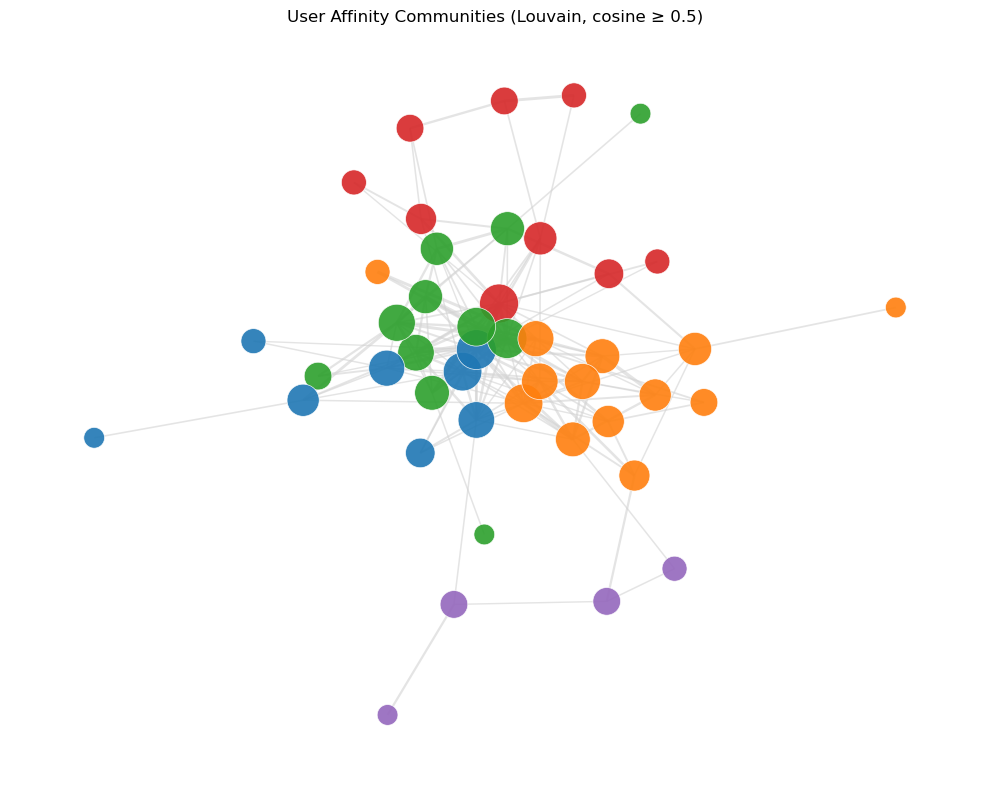

In [7]:
#  Louvain communities + top categories per community + network plot
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

SIM_PARQUET = "user_cosine_similarity.parquet"
USER_PROFILES_PARQUET = "user_profiles.parquet"   # rows=user_id, cols=TF-IDF categories
THRESHOLD = 0.5                              
TOPK_PER_COMMUNITY_FEATURES = 8                   # show top-N categories by mean weight

# 1) Load data
cos_sim_df = pd.read_parquet(SIM_PARQUET)
user_profiles = pd.read_parquet(USER_PROFILES_PARQUET)
# keep only numeric TF-IDF columns
feature_cols = user_profiles.select_dtypes(include=[np.number]).columns
user_profiles = user_profiles[feature_cols]

# sanity: indices align
assert (cos_sim_df.index == cos_sim_df.columns).all(), "Cosine matrix must have same users on rows/cols."
assert set(cos_sim_df.index).issubset(user_profiles.index), "User profiles must include all users in similarity matrix."
# align order
user_profiles = user_profiles.loc[cos_sim_df.index]

# 2) Build thresholded graph
A = cos_sim_df.to_numpy().astype(float)
A = np.maximum(A, A.T); np.fill_diagonal(A, 0.0)
users = cos_sim_df.index
i_idx, j_idx = np.where(A >= THRESHOLD)
edges = [(users[i], users[j], float(A[i, j])) for i, j in zip(i_idx, j_idx) if i < j]

G = nx.Graph()
G.add_nodes_from(users)
G.add_weighted_edges_from(edges)

print(f"Users: {G.number_of_nodes()} | Edges (cosine ≥ {THRESHOLD}): {G.number_of_edges()}")

# keep largest component for clean vizualization
if G.number_of_edges() > 0:
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()
    print(f"Largest component: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# 3) Louvain communities
try:
    import community as community_louvain  # python-louvain
    partition = community_louvain.best_partition(G, weight='weight', random_state=42)
except Exception as e:
    raise RuntimeError("Community detection requires 'python-louvain'. "
                       "Install it with `pip install python-louvain` and rerun.") from e

# map community ids to nodes and report sizes
comm_series = pd.Series(partition).rename("community").sort_index()
sizes = comm_series.value_counts().sort_index()
print("\nCommunity sizes:")
for cid, sz in sizes.items():
    print(f"  Community {cid}: {sz} users")

# 4) Top categories per community (by mean TF-IDF in user profiles)
community_tops = {}
for cid, members in comm_series.groupby(comm_series).groups.items():
    # members is list of user_ids in this community
    prof_mean = user_profiles.loc[list(members)].mean().sort_values(ascending=False)
    community_tops[cid] = prof_mean.head(TOPK_PER_COMMUNITY_FEATURES)

print("\nTop categories per community:")
for cid in sorted(community_tops):
    tops = community_tops[cid]
    print(f"\nCommunity {cid} (n={sizes[cid]}):")
    for feat, val in tops.items():
        print(f"  {feat}: {val:.3f}")

# 5) Plot network colored by community
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

pos = nx.spring_layout(G, k=0.9/np.sqrt(max(1, G.number_of_nodes())), seed=42, weight='weight')
communities = [partition[n] for n in G.nodes()]
unique_comms = sorted(set(communities))

# Define custom colors manually
community_colors = {
    0: "#1f77b4",  # blue
    1: "#ff7f0e",  # orange
    2: "#2ca02c",  # green
    3: "#d62728",  # red
    4: "#9467bd",  # purple
    5: "#8c564b",  # brown
}

# Fallback for undefined communities
default_color = "#7f7f7f"

# Assign colors based on community
node_colors = [community_colors.get(c, default_color) for c in communities]

# Node size and edge width
deg = dict(G.degree())
node_sizes = [50 + 250*np.log1p(deg[n]) for n in G.nodes()]
edge_widths = [1 + 3*(G[u][v]['weight'] - THRESHOLD) / max(1e-9, (1 - THRESHOLD)) for u, v in G.edges()]

# Plot
plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='lightgray', alpha=0.6)
nx.draw_networkx_nodes(G, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       alpha=0.9, linewidths=0.5, edgecolors='white')

plt.title(f"User Affinity Communities (Louvain, cosine ≥ {THRESHOLD})")
plt.axis('off')
plt.tight_layout()
plt.show()

Using largest component: 45 users, 164 edges


C:\Users\carol\conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


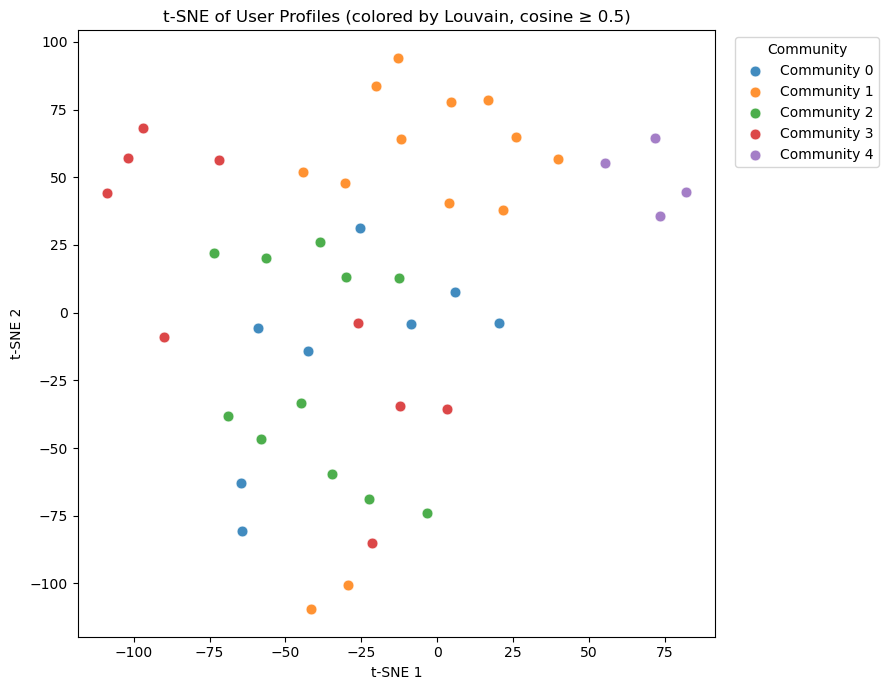

In [8]:
# t-SNE of user profiles colored by Louvain communities
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

SIM_PARQUET = "user_cosine_similarity.parquet"
USER_PROFILES_PARQUET = "user_profiles.parquet"
THRESHOLD = 0.50

# 1️) Load data
cos_sim_df = pd.read_parquet(SIM_PARQUET)
user_profiles = pd.read_parquet(USER_PROFILES_PARQUET)

# 2) Keep only numeric TF-IDF columns; align order to similarity matrix
feature_cols = user_profiles.select_dtypes(include=[np.number]).columns
user_profiles = user_profiles[feature_cols]
user_profiles = user_profiles.loc[cos_sim_df.index] 

# 3) Build thresholded graph and get the largest connected component
A = cos_sim_df.to_numpy().astype(float)
A = np.maximum(A, A.T)
np.fill_diagonal(A, 0.0)

users = cos_sim_df.index
i_idx, j_idx = np.where(A >= THRESHOLD)
edges = [(users[i], users[j], float(A[i, j])) for i, j in zip(i_idx, j_idx) if i < j]

G = nx.Graph()
G.add_nodes_from(users)
G.add_weighted_edges_from(edges)

largest_cc = max(nx.connected_components(G), key=len) if G.number_of_edges() > 0 else set(users)
Gcc = G.subgraph(largest_cc).copy()
users_cc = list(Gcc.nodes())

print(f"Using largest component: {len(users_cc)} users, {Gcc.number_of_edges()} edges")

# 4) Louvain communities on that component
import community as community_louvain  # pip install python-louvain
partition = community_louvain.best_partition(Gcc, weight='weight', random_state=42)

# 5) t-SNE of user profiles (cosine distance) for those users only
X = user_profiles.loc[users_cc].astype(float).values
Xn = normalize(X, norm='l2', axis=1)

# Compute cosine distance safely
cos_sim = cosine_similarity(Xn)
cos_sim = np.clip(cos_sim, -1, 1)         
cos_dist = 1.0 - cos_sim
cos_dist = np.maximum(cos_dist, 0.0)       

# Run t-SNE
perplexity = max(5, min(50, Xn.shape[0] // 5))
tsne = TSNE(
    n_components=2,
    metric='precomputed',
    perplexity=perplexity,
    learning_rate=200,
    n_iter=1500,
    random_state=42,
    init='random'
)
coords = tsne.fit_transform(cos_dist)

# 6) Plot colored by community
comm_ids = np.array([partition[u] for u in users_cc])
uniq = np.unique(comm_ids)
cmap = plt.colormaps.get_cmap('tab10')

plt.figure(figsize=(9,7))
for i, cid in enumerate(uniq):
    mask = comm_ids == cid
    plt.scatter(coords[mask, 0], coords[mask, 1],
                s=60, alpha=0.85, edgecolors='white', linewidths=0.5,
                label=f"Community {cid}", c=[cmap(i)])

plt.title(f"t-SNE of User Profiles (colored by Louvain, cosine ≥ {THRESHOLD})")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Community", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()



Influencers above the 85th percentile: 7 users


,degree,betweenness,closeness,eigenvector,community,composite_score
T4Uk_zyBFvIUsBVninUqRg,0.477273,0.231501,1.599208,0.346836,0,0.995556
_cRADNksh9fa_lrm_UnOuQ,0.477273,0.159619,1.575204,0.333369,2,0.975556
6kJFLAHV-tNsBEZaRTqEWQ,0.409091,0.187104,1.511497,0.272148,3,0.953333
YBUQi7JTik4_SRbFBv4GXQ,0.386364,0.053911,1.301385,0.229593,1,0.886667
zoS5f0JWThXQnpkxzzUUhQ,0.386364,0.045455,1.483924,0.304422,2,0.868889
XMHRH9_8T8HhjQMS81cdCw,0.272727,0.087738,1.299124,0.216488,0,0.860000
vS8H4lgp0AvtPSjrmKOQkg,0.295455,0.047569,1.271967,0.219857,2,0.837778



--- Global Network Metrics ---
Nodes: 45
Edges: 164
Density: 0.166
Average clustering coefficient: 0.365
Modularity (Louvain Q): 0.255


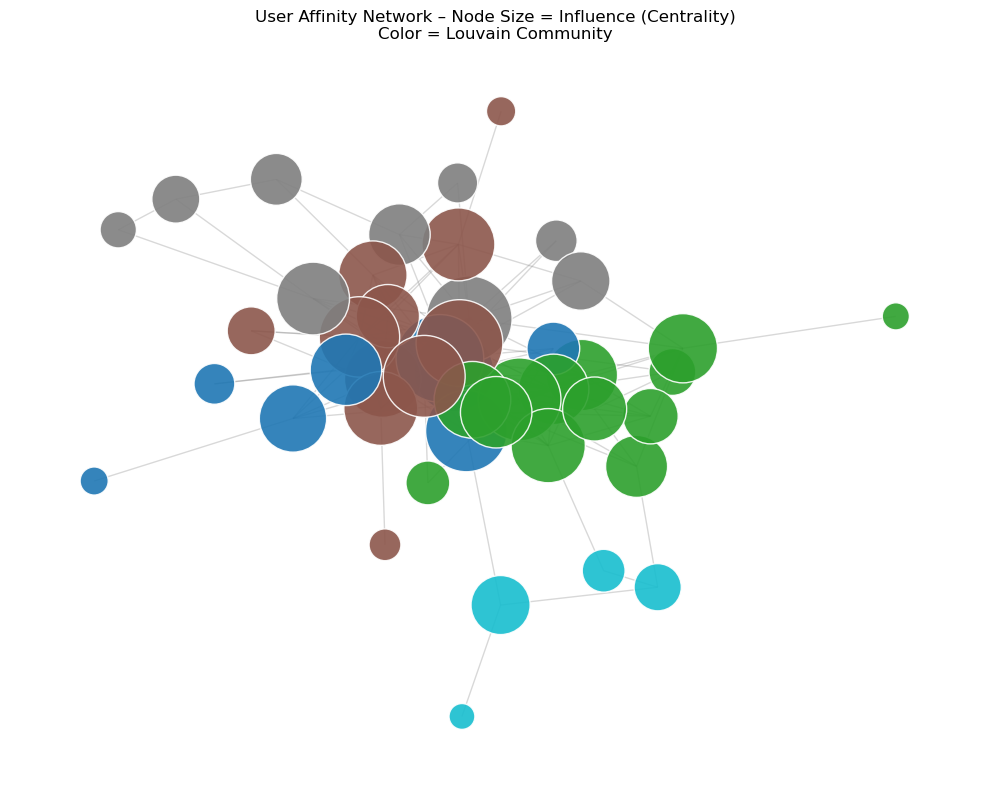

Saved full metrics → 'user_network_centrality_metrics.csv'
Saved influencer subset (≥85th percentile) → 'user_network_influencers_85th.csv'


In [9]:
# Advanced Network Metrics: Centrality, Modularity & Influence Analysis
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import community as community_louvain 

# Compute centrality measures
deg_cent = nx.degree_centrality(Gcc)
bet_cent = nx.betweenness_centrality(Gcc, weight=lambda u, v, d: 1 - d.get('weight', 0.0), normalized=True)
close_cent = nx.closeness_centrality(Gcc, distance=lambda u, v, d: 1 - d.get('weight', 0.0))
eig_cent = nx.eigenvector_centrality_numpy(Gcc, weight='weight')

# Combine into DataFrame
centrality_df = pd.DataFrame({
    "degree": pd.Series(deg_cent),
    "betweenness": pd.Series(bet_cent),
    "closeness": pd.Series(close_cent),
    "eigenvector": pd.Series(eig_cent),
    "community": pd.Series(partition)
})

# Compute composite influence score (normalized ranks)
centrality_df["composite_score"] = (
    0.4 * centrality_df["degree"].rank(pct=True) +
    0.3 * centrality_df["betweenness"].rank(pct=True) +
    0.2 * centrality_df["eigenvector"].rank(pct=True) +
    0.1 * centrality_df["closeness"].rank(pct=True)
)

# Determine influencers by percentile (e.g., top 15%)
PERCENTILE = 0.85
cutoff = centrality_df["composite_score"].quantile(PERCENTILE)
influencers_df = centrality_df[centrality_df["composite_score"] >= cutoff].sort_values(
    "composite_score", ascending=False
)

print(f"\nInfluencers above the {int(PERCENTILE * 100)}th percentile: {len(influencers_df)} users")
display(influencers_df)

# Compute global network metrics
modularity_Q = community_louvain.modularity(partition, Gcc)
density = nx.density(Gcc)
avg_clustering = nx.average_clustering(Gcc, weight='weight')

print("\n--- Global Network Metrics ---")
print(f"Nodes: {Gcc.number_of_nodes()}")
print(f"Edges: {Gcc.number_of_edges()}")
print(f"Density: {density:.3f}")
print(f"Average clustering coefficient: {avg_clustering:.3f}")
print(f"Modularity (Louvain Q): {modularity_Q:.3f}")

# Visualize network (size = influence)
pos = nx.spring_layout(Gcc, seed=42, weight='weight')

plt.figure(figsize=(10, 8))
node_sizes = 4000 * centrality_df["composite_score"]
node_colors = [centrality_df.loc[n, "community"] for n in Gcc.nodes()]

nx.draw_networkx_edges(Gcc, pos, alpha=0.3, edge_color='gray')
nx.draw_networkx_nodes(
    Gcc,
    pos,
    node_size=node_sizes,
    cmap='tab10',
    node_color=node_colors,
    alpha=0.9,
    edgecolors='white'
)

plt.title("User Affinity Network – Node Size = Influence (Centrality)\nColor = Louvain Community")
plt.axis('off')
plt.tight_layout()
plt.show()

# Save metrics
centrality_df.to_csv("user_network_centrality_metrics.csv")
influencers_df.to_csv("user_network_influencers_85th.csv")
print("Saved full metrics → 'user_network_centrality_metrics.csv'")
print("Saved influencer subset (≥85th percentile) → 'user_network_influencers_85th.csv'")


## **Time series analysis and Forecast**

In [29]:
!pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 2.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.5 MB/s eta 0:00:0000:01


In [144]:
import pandas as pd
df = pd.read_parquet("/home/jovyan/work/content/DF_PA_only_restaurants_and_open_business.parquet")
df_user_group = pd.read_csv("/home/jovyan/work/content/User_in_communities_threshold=0.5.csv").drop("in_component",axis=1)
df_with_comunity = df.merge(df_user_group, how="left", left_on="user_id", right_on="user").copy()
df_with_comunity['community'] = df_with_comunity['community'].fillna(99)
df_with_comunity = df_with_comunity[df_with_comunity["community"]==99]
df_with_comunity.head()

,review_id,user_id,business_id,stars_x,text,date,review_count_x,average_stars,name_y,address,city,state,postal_code,stars_y,review_count_y,is_open,attributes,categories,user,community
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,33,4.06,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,3.0,169,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Restaurants, Breakfast & Brunch, Food, Juice B...",NaN,99.0
1,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,9,4.78,Zaika,2481 Grant Ave,Philadelphia,PA,19114,4.0,181,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Halal, Pakistani, Restaurants, Indian",NaN,99.0
2,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,2,5.00,Rittenhouse Grill,1701 Locust St,Philadelphia,PA,19103,3.5,290,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Wine Bars, Restaurants, Nightlife, Steakhouses...",NaN,99.0
3,Xs8Z8lmKkosqW5mw_sVAoA,IQsF3Rc6IgCzjVV9DE8KXg,eFvzHawVJofxSnD7TgbZtg,5,My absolute favorite cafe in the city. Their b...,2014-11-12 15:30:27,182,3.41,Good Karma Cafe,928 Pine St,Philadelphia,PA,19107,4.0,249,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Food, Cafes, Coffee & Tea, Restaurants",NaN,99.0
4,G_5UczbCBJriUAbxz3J7Tw,clWLI5OZP2ad25ugMVI8gg,x4XdNhp0Xn8lOivzc77J-g,5,Best thai food in the area. Everything was au...,2013-08-15 15:27:51,17,3.24,Thai Place Restaurant,"700 Nutt Rd, Ste 730",Phoenixville,PA,19460,4.5,222,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Thai, Restaurants",NaN,99.0


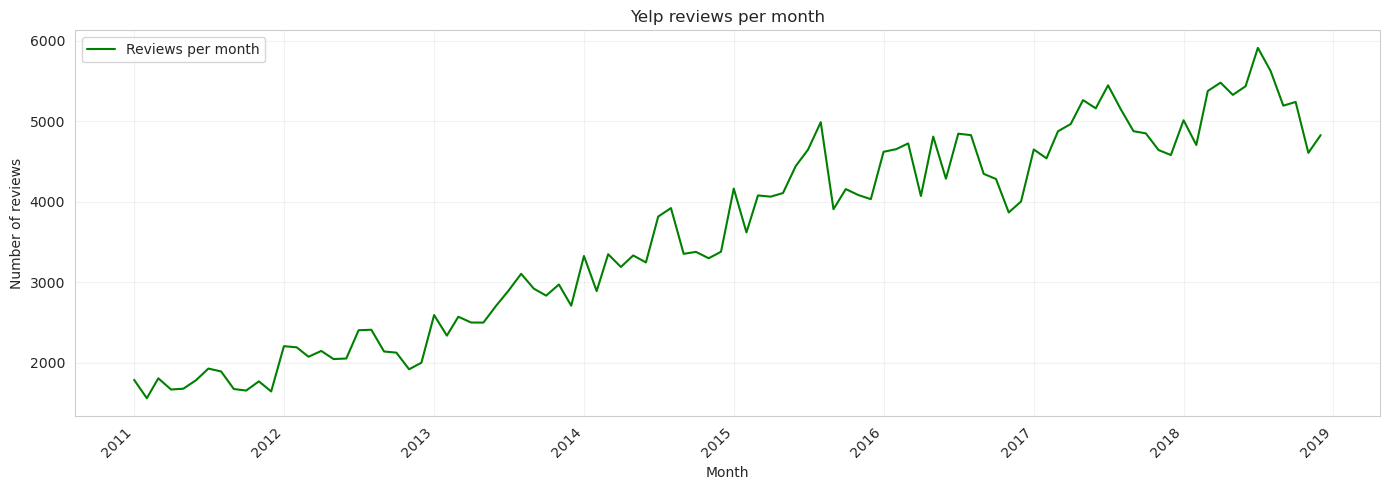

In [145]:
import matplotlib.pyplot as plt
df_with_comunity["date"] = pd.to_datetime(df["date"])        # parse datetimes
daily = df_with_comunity.groupby(df_with_comunity["date"].dt.date).size()
df_with_comunity = df_with_comunity[df_with_comunity["date"].dt.year > 2010]  # count per day (index = date)
df_with_comunity = df_with_comunity[df_with_comunity["date"].dt.year < 2019]  # count per day (index = date)
daily = daily.sort_index()                     # ensure chronological order

# Aggregate by month (normalize to first day of month)
monthly = df_with_comunity.groupby(df_with_comunity["date"].dt.to_period("M")).size()
monthly.index = monthly.index.to_timestamp()   # convert PeriodIndex → Timestamp
# Plot
plt.figure(figsize=(14,5))
plt.plot(monthly.index, monthly.values,color="green", label="Reviews per month")
plt.xlabel("Month")
plt.ylabel("Number of reviews")
plt.title("Yelp reviews per month")
plt.grid(alpha=0.25)
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.savefig("original_time_series.png")
plt.show()

In [146]:
def check_missing_times(series, freq="M"):
    """
    Check for missing timestamps in a pandas Series with a DatetimeIndex.

    Parameters
    ----------
    series : pd.Series
        Series with DatetimeIndex.
    freq : str, default "M"
        Frequency of expected timestamps (e.g. "D", "M", "H", etc.)

    Returns
    -------
    missing : pd.DatetimeIndex
        DatetimeIndex of missing timestamps.
    """
    if not isinstance(series.index, pd.DatetimeIndex):
        raise TypeError("Series index must be a DatetimeIndex.")
    
    idx = series.index.drop_duplicates().sort_values()
    full_range = pd.date_range(start=idx.min(), end=idx.max(), freq=freq)
    missing = full_range.difference(idx)
    return missing

check_missing_times(monthly,"MS").to_list()


[]

In [147]:
import numpy as np
from statsmodels.tsa.seasonal import STL


# Fill missing months with 0
full_index = pd.date_range(start=monthly.index.min(), end=monthly.index.max(), freq="MS")
monthly = monthly.reindex(full_index, fill_value=0)

# --- Log transform ---
monthly_log = np.log(monthly)  # log(1 + x) avoids log(0) issue

# --- STL decomposition ---
stl = STL(monthly_log,period=12, robust=True)
result = stl.fit()


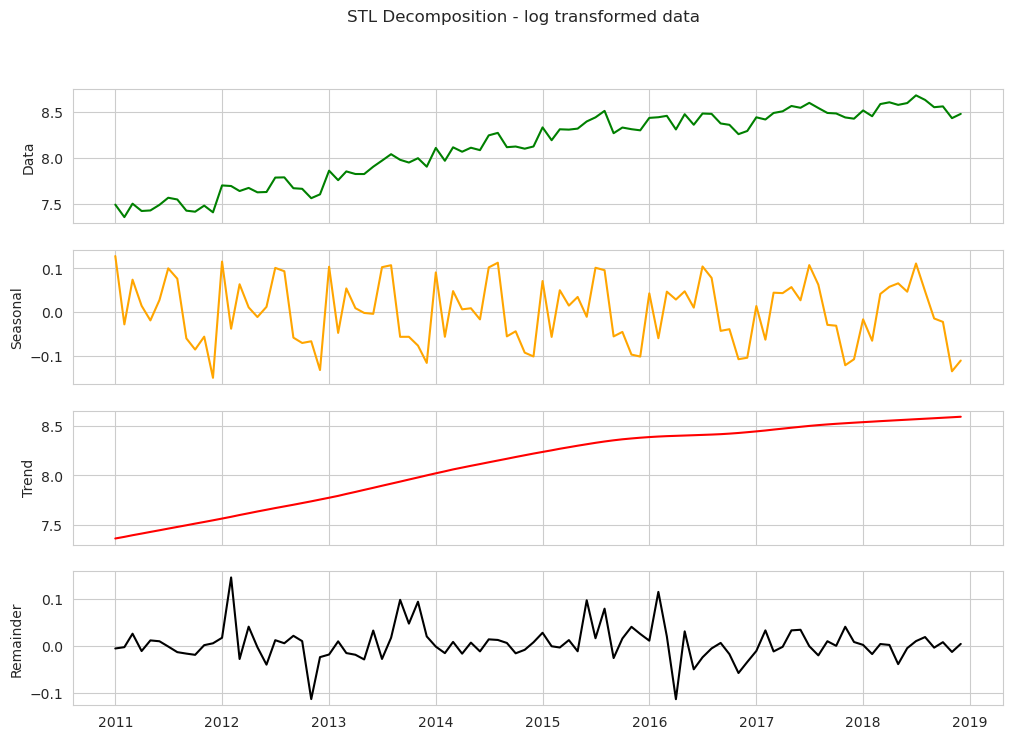

In [148]:
def plot_stl(ts, stl_result, title="STL Decomposition"):
    fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

    axes[0].plot(ts, label="Data", color='green')
    axes[0].set_ylabel("Data")

    axes[1].plot(stl_result.seasonal, label="Seasonal", color='orange')
    axes[1].set_ylabel("Seasonal")

    axes[2].plot(stl_result.trend, label="Trend", color= "red")
    axes[2].set_ylabel("Trend")

    axes[3].plot(stl_result.resid, label="Remainder", color='black')
    axes[3].set_ylabel("Remainder")

    plt.suptitle(title)
    plt.savefig("STL_decomposition.png")
    plt.show()

plot_stl(monthly_log, result, title="STL Decomposition - log transformed data")

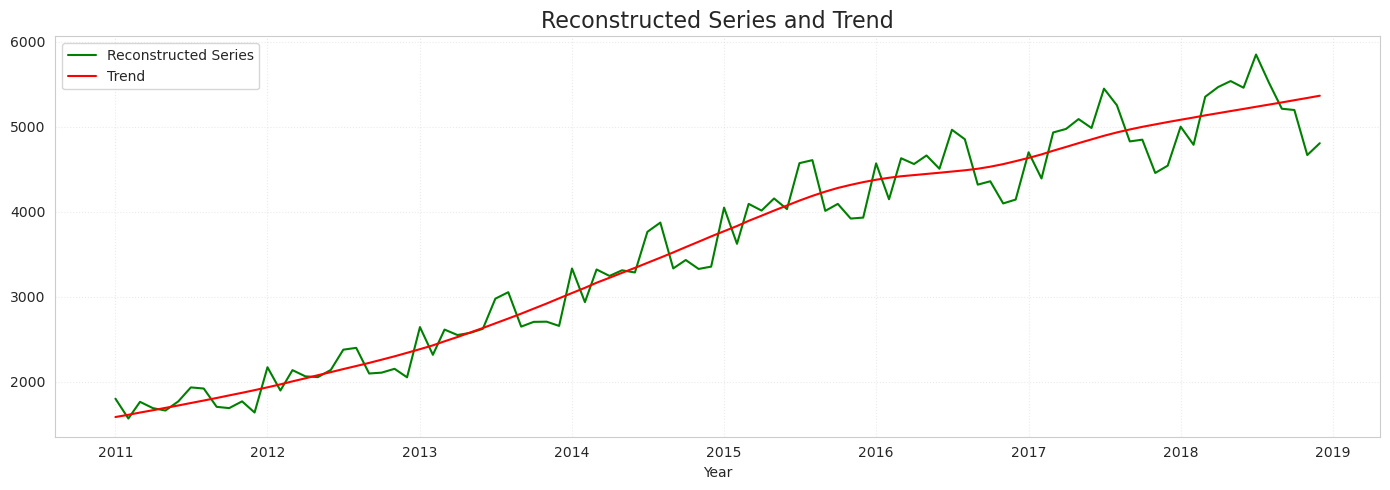

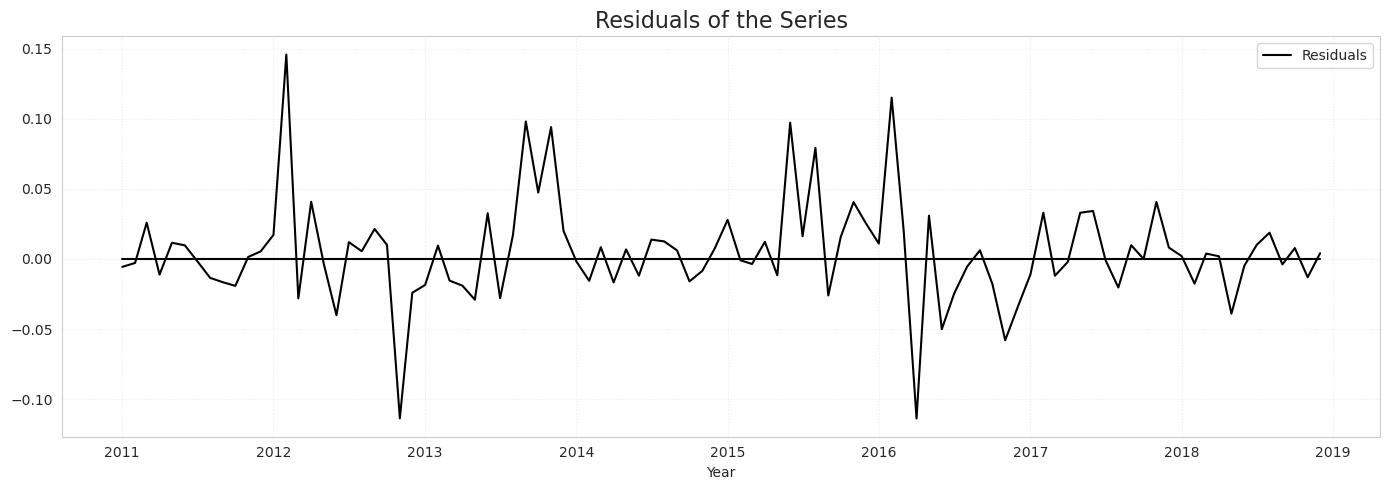

In [149]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Extract components ---
trend = result.trend
seasonal = result.seasonal
reconstructed = trend + seasonal  # Reconstructed series
residual = monthly_log - reconstructed

#residual = np.exp(residual)
trend= np.exp(trend)
reconstructed = np.exp(reconstructed)
 

# --- Plot 1: Reconstructed series with trend ---
plt.figure(figsize=(14, 5))
plt.plot(reconstructed.index, reconstructed, label="Reconstructed Series", color="green")
plt.plot(trend.index, trend, label="Trend", color="red")
plt.title("Reconstructed Series and Trend", fontsize=16)
plt.xlabel("Year")
plt.legend()
plt.grid(True, which="both", linestyle=":", alpha=0.4)

# Format x-axis for yearly ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.savefig("reconstructed_series.png")
plt.show()

# --- Plot 2: Residuals ---
plt.figure(figsize=(14, 5))
plt.plot(residual.index, residual, label="Residuals", color="black")
plt.plot(residual.index,np.zeros(len(residual)),color="black")
plt.title("Residuals of the Series", fontsize=16)
plt.xlabel("Year")
plt.legend()
plt.grid(True, which="both", linestyle=":", alpha=0.4)

# Format x-axis for yearly ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.savefig("resid.png")
plt.tight_layout()
plt.show()


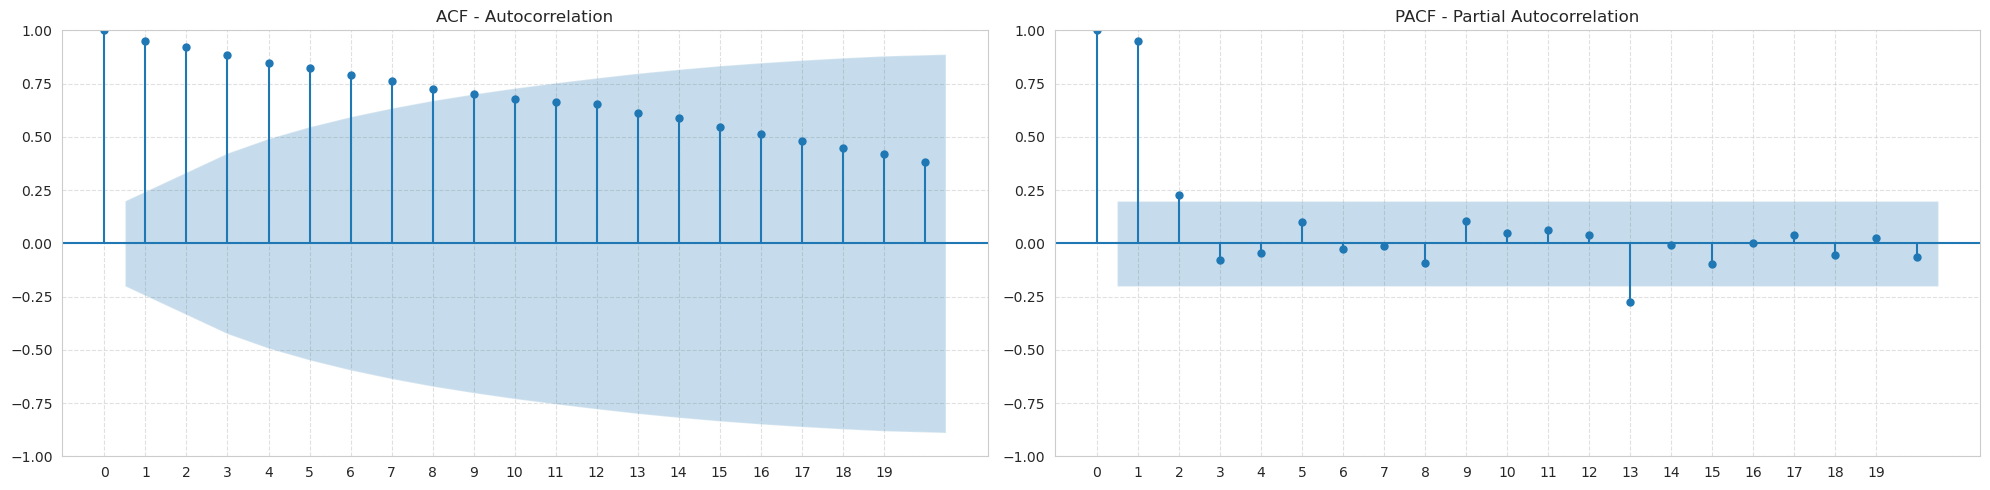

In [150]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np

# --- Plot ACF & PACF with all ticks shown ---
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# ACF
plot_acf(monthly, lags=20, ax=axes[0])
axes[0].set_title("ACF - Autocorrelation")
axes[0].set_xticks(np.arange(0, 20, 1))  # Show every tick from 0 to 50
axes[0].grid(True, linestyle="--", alpha=0.6)

# PACF
plot_pacf(monthly, lags=20, ax=axes[1], method="ywm")  # Yule-Walker Modified
axes[1].set_title("PACF - Partial Autocorrelation")
axes[1].set_xticks(np.arange(0, 20, 1))  # Show every tick from 0 to 50
axes[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


=== Grid Search Results (Top 10) ===
    error trend seasonal  periods         MAE        RMSE         AIC  \
127   mul   add      mul       12  599.692008  653.773187  948.439090   
166   mul   mul      mul       12  274.561156  339.679741  949.399875   
114   mul   add      add       12  569.334078  636.284290  955.690663   
23    add   add      mul       12  480.806514  540.279136  963.194783   
205   mul  None      mul       12  761.668088  810.223398  964.665475   
62    add   mul      mul       12  862.402150  908.074559  965.456330   
192   mul  None      add       12  946.521817  988.680572  971.921142   
101   add  None      mul       12  796.640319  841.775977  975.658910   
10    add   add      add       12  553.602976  614.375643  977.808663   
121   mul   add      mul        6  657.930801  758.849879  986.099184   

             BIC  
127   989.419080  
166   990.379865  
114   996.670653  
23   1004.174773  
205  1001.092133  
62   1006.436320  
192  1008.347800  
101  1

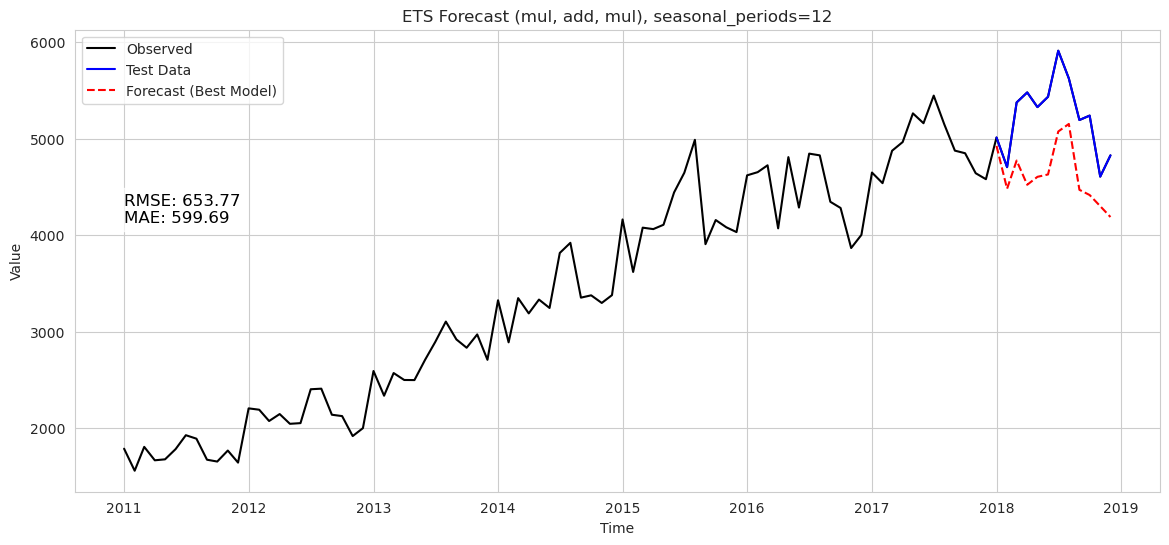

In [151]:
train_series = monthly[monthly.index.year < 2017]  # count per day (index = date)
test_series = monthly[monthly.index.year > 2017]
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import itertools

# Assume `train_series` and `test_series` are defined
# Example:
# train_series = monthly[monthly.index.year < 2018]
# test_series  = monthly[monthly.index.year >= 2018]

# Parameter grid
error_types = ["add", "mul"]
trend_types = ["add", "mul", None]
seasonal_types = ["add", "mul", None]
seasonal_periods = list(range(2, 15))  # 2 to 14

results = []

# --- Grid Search (no cross-validation) ---
for error, trend, seasonal, periods in itertools.product(
    error_types, trend_types, seasonal_types, seasonal_periods
):
    if seasonal is None and trend is None:
        continue  # skip too simple models

    try:
        model = ETSModel(
            train_series,
            error=error,
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=periods
        )
        fit = model.fit(disp=False)
        forecast = fit.forecast(steps=len(test_series))

        mae = mean_absolute_error(test_series, forecast)
        rmse = np.sqrt(mean_squared_error(test_series, forecast))
        aic = fit.aic
        bic = fit.bic

        results.append({
            "error": error,
            "trend": trend,
            "seasonal": seasonal,
            "periods": periods,
            "MAE": mae,
            "RMSE": rmse,
            "AIC":aic,
            "BIC":bic
        })

    except Exception as e:
        print(f"Skipped ({error}, {trend}, {seasonal}, {periods}) due to: {e}")
        continue

# --- Collect and show results ---
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="AIC")
print("\n=== Grid Search Results (Top 10) ===")
print(results_df.head(10))

# --- Best model ---
best = results_df.iloc[0]
print(f"\nBest configuration:\n{best}")

# --- Refit best model on full data ---
best_model = ETSModel(
    train_series,
    error=best["error"],
    trend=best["trend"],
    seasonal=best["seasonal"],
    seasonal_periods=best["periods"]
).fit(disp=False)

forecast = best_model.forecast(steps=len(test_series))
mae = mean_absolute_error(test_series, forecast)
rmse = np.sqrt(mean_squared_error(test_series, forecast))

# --- Plot results ---
plt.figure(figsize=(14,6))
plt.plot(monthly, label="Observed", color="black")
plt.plot(test_series.index, test_series, label="Test Data", color="blue")

# Forecast from best model
forecast_values = forecast
plt.plot(test_series.index, forecast_values, linestyle="--", color="red", label="Forecast (Best Model)")

plt.text(train_series.index[0], max(monthly)*0.75, f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}',
         fontsize=12, color='black', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))



plt.title(f"ETS Forecast ({best['error']}, {best['trend']}, {best['seasonal']}), "
          f"seasonal_periods={best['periods']}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.savefig("best_ets_model.png")
plt.show()


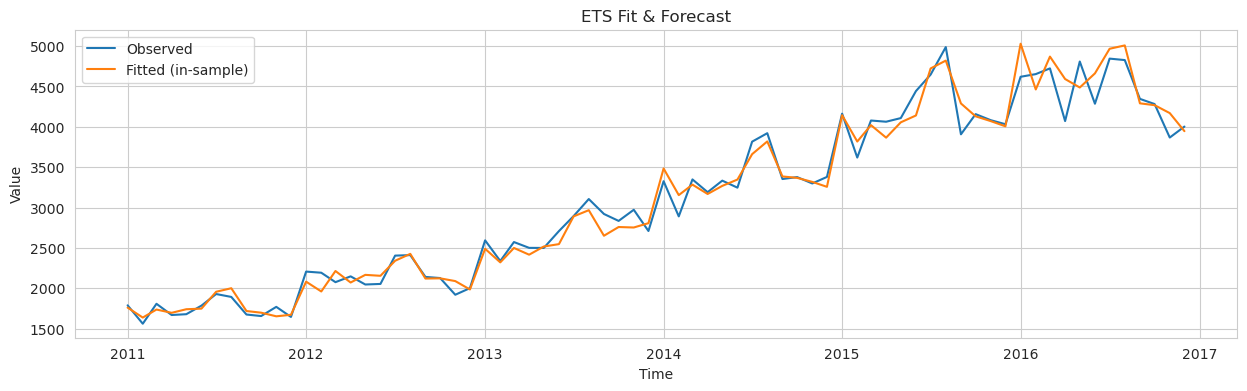

In [152]:
fitted = best_model.fittedvalues
plt.figure(figsize=(15, 4))
plt.plot(train_series, label="Observed")
plt.plot(fitted.index, fitted, label="Fitted (in-sample)")
plt.legend()
plt.title("ETS Fit & Forecast")
plt.xlabel("Time")
plt.ylabel("Value")
plt.savefig("best_ets_model_fitted.png")
plt.show()

Min p-value across lags: 0.1232
Residuals behave like white noise (no significant autocorrelation).


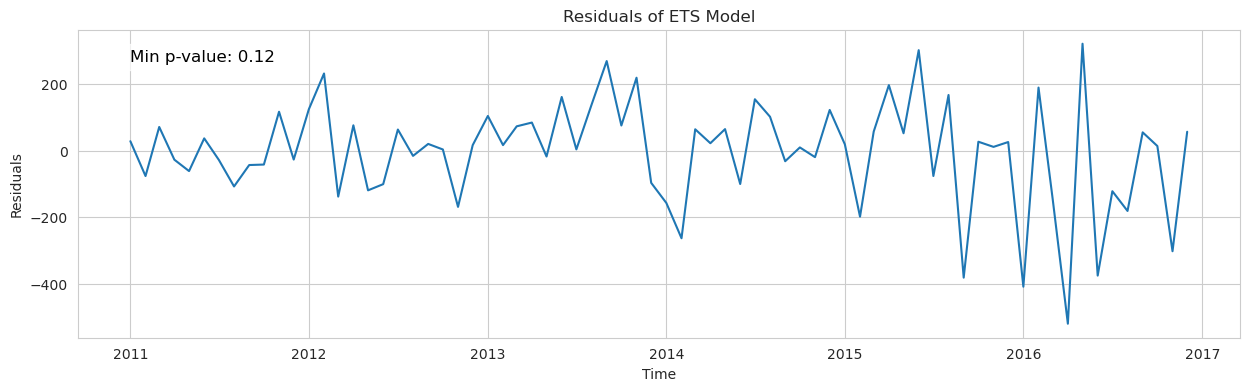

In [153]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Calculate residuals
residuals = train_series - fitted

# Perform Ljung-Box test
lags = 30
lb_test = sm.stats.acorr_ljungbox(residuals, lags=lags, return_df=True)

# One value to summarize: min p-value (conservative)
min_pvalue = lb_test['lb_pvalue'].min()
print(f"Min p-value across lags: {min_pvalue:.4f}")

if min_pvalue > 0.05:
    print("Residuals behave like white noise (no significant autocorrelation).")
else:
    print("Residuals show autocorrelation (not white noise).")

# Optional: plot residuals
plt.figure(figsize=(15, 4))
plt.plot(residuals)
plt.title("Residuals of ETS Model")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.text(residuals.index[0], max(residuals)*0.95, f'Min p-value: {min_pvalue:.2f}',
         fontsize=12, color='black', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))
plt.savefig("best_ets_model_fitted_residuals.png")
plt.show()


ADF Statistic: -9.939539098664385
p-value: 2.6871765084629937e-17
Critical Values:
   1%: -3.5260
   5%: -2.9032
   10%: -2.5890

✅ The series is likely stationary (reject H₀).


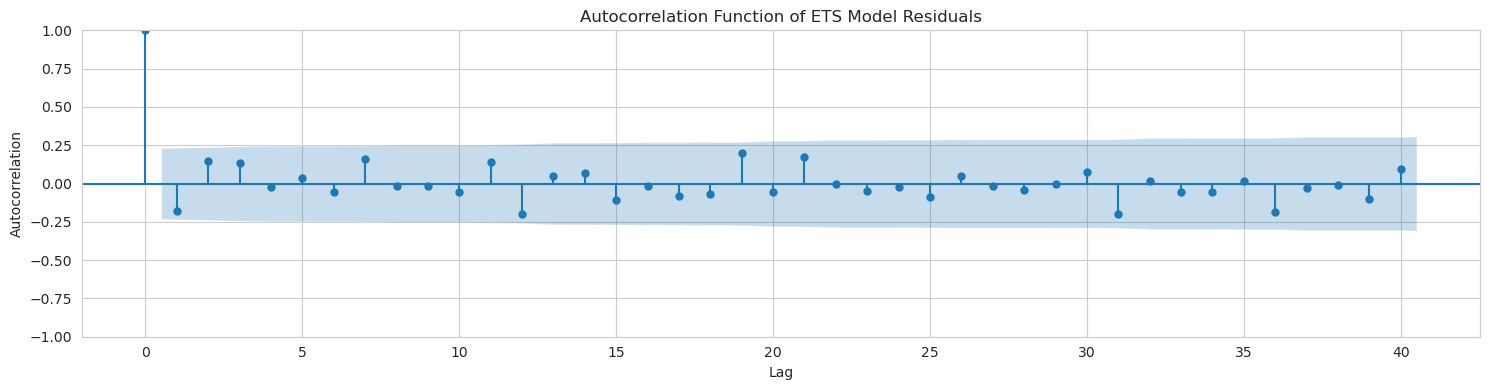

In [154]:
from statsmodels.tsa.stattools import adfuller


result = adfuller(residuals)

# Display results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value:.4f}')

# Interpretation
if result[1] < 0.05:
    print("\n✅ The series is likely stationary (reject H₀).")
else:
    print("\n❌ The series is likely non-stationary (fail to reject H₀).")
    
fig, ax = plt.subplots(figsize=(15, 4))  # wider and shorter
plot_acf(residuals, lags=40, alpha=0.05, ax=ax)
ax.set_title("Autocorrelation Function of ETS Model Residuals")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
plt.tight_layout()
plt.savefig("ACL_ets_model_fitted_residuals.png", bbox_inches="tight")
plt.show()

After 1 differences: ADF p-value = 0.0044
✅ Stationary after 1 differences (p=0.0044).


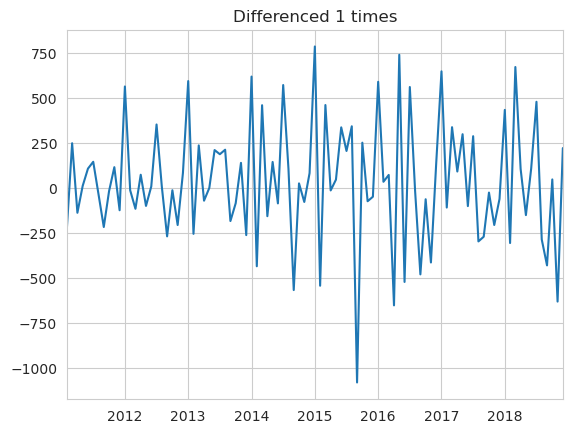

In [155]:

from statsmodels.tsa.stattools import adfuller
def make_stationary(y, significance=0.05, max_diff=5):
    """
    Difference the series until it becomes stationary based on the ADF test.
    Returns the stationary series and number of differences.
    """
    y_diff = y.copy()
    d = 0
    pvalue = adfuller(y_diff.dropna())[1]

    while pvalue > significance and d < max_diff:
        d += 1
        y_diff = y_diff.diff().dropna()
        pvalue = adfuller(y_diff)[1]
        print(f"After {d} differences: ADF p-value = {pvalue:.4f}")

    if pvalue > significance:
        print("⚠️ Series may still be non-stationary after max differencing.")
    else:
        print(f"✅ Stationary after {d} differences (p={pvalue:.4f}).")

    return y_diff, d

y_stationary, d = make_stationary(monthly)
y_stationary.plot(title=f"Differenced {d} times")
plt.show()


22:24:04 - cmdstanpy - INFO - Chain [1] start processing
22:24:04 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 193.19 | MAE: 169.30


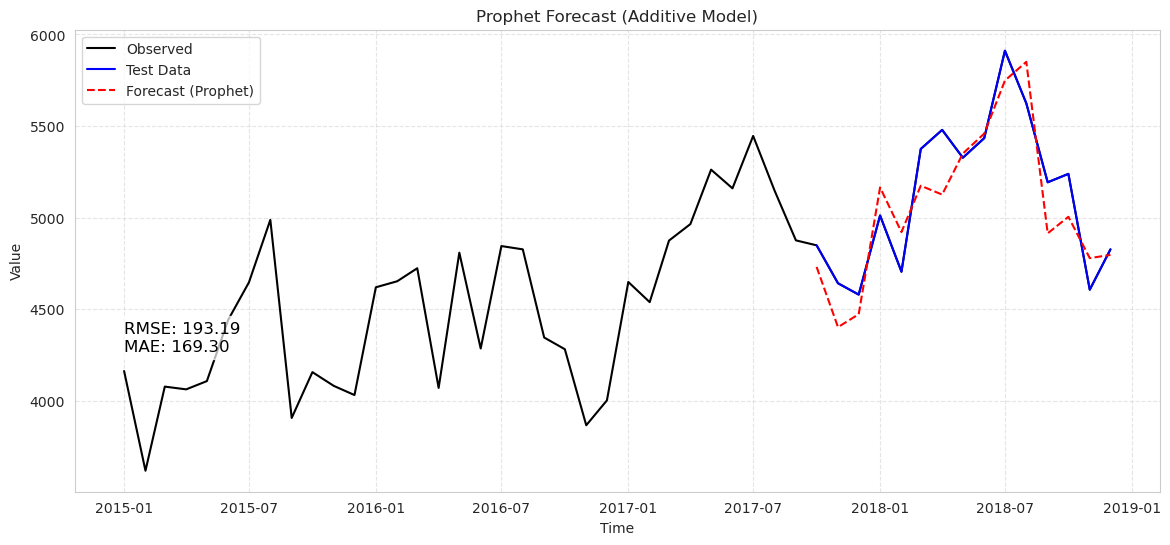

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Suppose your series is named `monthly`
# Example: monthly.index = pd.date_range(...), monthly.values = numeric
monthly = monthly[monthly.index.year > 2014]
df = monthly.reset_index()
df.columns = ['ds', 'y']  # Prophet requires these exact names

# --- Train/test split ---
train_size = int(len(df) * 0.7)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# --- Fit Prophet model ---
model = Prophet(seasonality_mode="multiplicative", yearly_seasonality=True)
model.fit(train_df)

# --- Forecast future points equal to test size ---
future = model.make_future_dataframe(periods=len(test_df), freq="MS")
forecast = model.predict(future)

# --- Extract only forecasted (test) values ---
forecast_values = forecast.tail(len(test_df))["yhat"].values

# --- Evaluate ---
rmse = np.sqrt(mean_squared_error(test_df["y"], forecast_values))
mae = mean_absolute_error(test_df["y"], forecast_values)
print(f"RMSE: {rmse:.2f} | MAE: {mae:.2f}")

# --- Plot ---
plt.figure(figsize=(14,6))
plt.plot(df["ds"], df["y"], label="Observed", color="black")
plt.plot(test_df["ds"], test_df["y"], label="Test Data", color="blue")
plt.plot(test_df["ds"], forecast_values, linestyle="--", color="red", label="Forecast (Prophet)")

plt.text(
    train_df["ds"].iloc[0],
    df["y"].max() * 0.75,
    f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}',
    fontsize=12,
    color='black',
    verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.7)
)

plt.title("Prophet Forecast (Additive Model)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig("prophet_forecast.png", dpi=300)
plt.show()


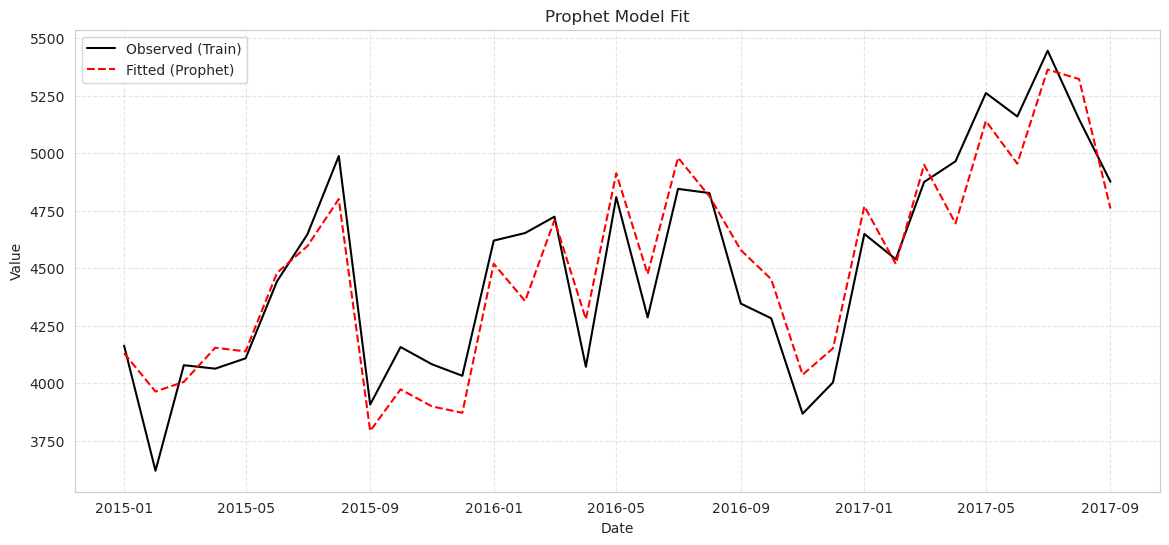

In [157]:
# Predicted (fitted) values for the training set
fitted_values = forecast.head(len(train_df))["yhat"].values

# Residuals = actual - fitted
residuals = train_df["y"].values - fitted_values

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(train_df["ds"], train_df["y"], label="Observed (Train)", color="black")
plt.plot(train_df["ds"], fitted_values, label="Fitted (Prophet)", color="red", linestyle="--")
plt.title("Prophet Model Fit")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


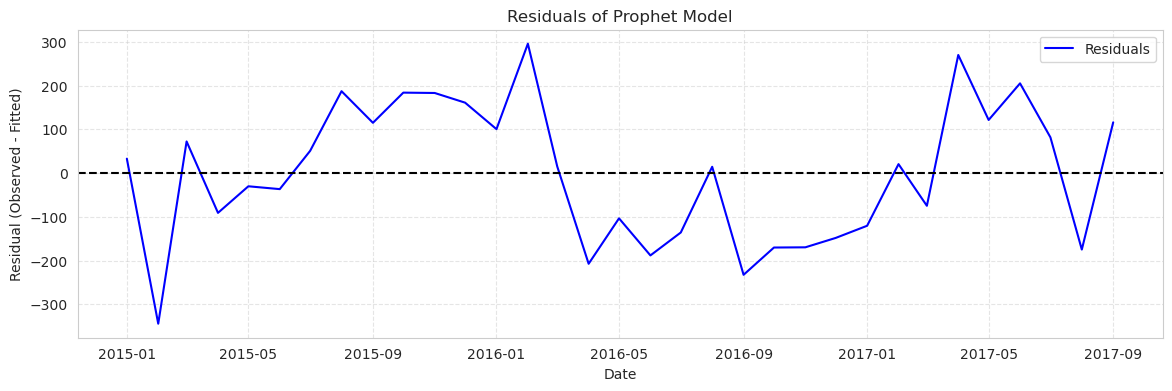

In [158]:
plt.figure(figsize=(14,4))
plt.plot(train_df["ds"], residuals, label="Residuals", color="blue")
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals of Prophet Model")
plt.xlabel("Date")
plt.ylabel("Residual (Observed - Fitted)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [159]:
# Perform Ljung-Box test
lags = 10
lb_test = sm.stats.acorr_ljungbox(residuals, lags=lags, return_df=True)

# One value to summarize: min p-value (conservative)
min_pvalue = lb_test['lb_pvalue'].min()
print(f"Min p-value across lags: {min_pvalue:.4f}")

if min_pvalue > 0.05:
    print("Residuals behave like white noise (no significant autocorrelation).")
else:
    print("Residuals show autocorrelation (not white noise).")

Min p-value across lags: 0.0001
Residuals show autocorrelation (not white noise).
